In [1]:
from cavity import *
import pickle as pkl
from matplotlib import rc

import ipywidgets as widgets
from ipywidgets import Layout, interact, FloatSlider

np.set_printoptions(precision=10, linewidth=151)
import winsound
from time import time

def print_parameters_func(local_parameters):
    for key, value in local_parameters.items():
        if key.startswith("t_") or key.startswith("p_") or key in ["t", "p"]:
            print(f"{key} = 1j*{value/np.pi:.10e}")
        elif isinstance(value, float):
            print(f"{key} = {value:.10e}")
        else:
            print(f"{key} = {value}")

with open('data/params_dict.pkl', 'rb') as f:
    params_dict = pkl.load(f)
            
%matplotlib inline

# Set up explorations - setting mode and lens properties

In [2]:
font = {'size'   : 10}
rc('font', **font)
lambda_laser = 1.064e-6


def f(power, waist_to_left_mirror, symmetric_left_arm, mode_3_center, mode_3_center_fine, x_2, x_2_perturbation, NA_3, right_arm_length, right_mirror_radius_shift, right_mirror_position_shift, auto_set_right_arm_length,
      mirror_on_waist, R, R_small_perturbation, w, w_small_perturbation, n, lens_thermal_properties_override, lens_fixed_properties, alpha_lens,
      beta_lens, kappa_lens, dn_dT_lens, nu_lens, alpha_absorption_lens, auto_set_x, x_span, auto_set_y, y_span, camera_center,
      print_input_parameters, print_parameters):

    if print_input_parameters:
        print_parameters_func(locals())
    
    R = 10 ** R
    R += R_small_perturbation
    w = 10 ** w
    w += w_small_perturbation
    right_arm_length = 10 ** right_arm_length
    x_span = 10 ** x_span
    y_span = 10 ** y_span
    mode_3_center += mode_3_center_fine
    # Generate left arm's mirror:
    z_R_3 = lambda_laser / (np.pi * NA_3 ** 2)
    if symmetric_left_arm:
        half_length = (x_2 - w/2) - mode_3_center
        x_3 = mode_3_center - half_length
    else:
        x_3 = mode_3_center - waist_to_left_mirror
    mode_3_center = np.array([mode_3_center, 0, 0])
    mode_3_k_vector = np.array([1, 0, 0])
    mode_3 = ModeParameters(center=np.stack([mode_3_center, mode_3_center], axis=0), k_vector=mode_3_k_vector,
                            z_R=np.array([z_R_3, z_R_3]),
                            principle_axes=np.array([[0, 0, 1], [0, 1, 0]]), lambda_laser=lambda_laser)
    mirror_3 = match_a_mirror_to_mode(mode_3, x_3 - mode_3.center[0, 0], PHYSICAL_SIZES_DICT['thermal_properties_ULE'])

    # Generate lens:
    if lens_thermal_properties_override:
        alpha_lens, beta_lens, kappa_lens, dn_dT_lens, nu_lens, alpha_absorption_lens = PHYSICAL_SIZES_DICT[
            f"thermal_properties_{lens_fixed_properties}"].to_array
        n = PHYSICAL_SIZES_DICT['refractive_indices'][lens_fixed_properties]
    lens_params = np.array(
        [x_2, 0, 0, 0, R, n, w, 1, 0, 0, alpha_lens, beta_lens, kappa_lens, dn_dT_lens, nu_lens, alpha_absorption_lens,
         1])
    surface_3, surface_1 = generate_lens_from_params(lens_params, names=['lens_left', 'lens_right'])
    local_mode_3 = mode_3.local_mode_parameters(np.linalg.norm(surface_3.center - mode_3.center[0]))
    local_mode_1 = local_mode_2_of_lens_parameters(np.array([R, w, n]), local_mode_3)
    mode_1 = local_mode_1.to_mode_parameters(location_of_local_mode_parameter=surface_1.center,
                                             k_vector=mode_3_k_vector, lambda_laser=lambda_laser)

    if auto_set_right_arm_length:
        z_minus_z_0 = - local_mode_1.z_minus_z_0[0]
    elif mirror_on_waist:
        z_minus_z_0 = 0
    else:
        z_minus_z_0 = local_mode_1.z_minus_z_0[0] + right_arm_length

    mirror_1 = match_a_mirror_to_mode(mode_1, z_minus_z_0, PHYSICAL_SIZES_DICT['thermal_properties_ULE'])
    mirror_1.radius += right_mirror_radius_shift
    mirror_1.origin += np.array([right_mirror_position_shift-right_mirror_radius_shift, 0, 0])
    mirror_3_params = mirror_3.to_params
    mirror_1_params = mirror_1.to_params
    lens_params = lens_params.astype(np.complex128)
    lens_params[3] = 1j
    params = np.stack([mirror_1_params, lens_params, mirror_3_params], axis=0)
    params[1, 0] += x_2_perturbation

    cavity = Cavity.from_params(params,
                                lambda_laser=lambda_laser,
                                standing_wave=True,
                                p_is_trivial=True,
                                t_is_trivial=True,
                                set_mode_parameters=True,
                                names=['Left mirror', 'Lens_left', 'lens_right', 'Right mirror'],
                                power=power)
    unheated_cavity = cavity.thermal_transformation()
    fig, ax = plt.subplots(2, 1, figsize=(12, 12))
    cavity.plot(axis_span=x_span, camera_center=camera_center, ax=ax[1])
    ax[1].set_title(
        f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.3e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.3e} [m]\n"  # 
        f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.3e}, long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.3e} [m]\n"  # 
        f"R_left={mirror_3.radius:.2e} R_lens = {R:.2e}, w_lens={w:.3e}, {n=:.2e}, R_right={mirror_1.radius:.2e}, spot size={2*cavity.arms[2].mode_parameters_on_surface_2.spot_size(cavity.lambda_laser)[0]:.2e}")
    plt.grid()
    if auto_set_x:
        cavity_length = mirror_1.center[0] - mirror_3.center[0]
        ax[1].set_xlim(mirror_3.center[0] - 0.01 * cavity_length, mirror_1.center[0] + 0.01 * cavity_length)
    if auto_set_y:
        y_lim = maximal_lens_height(R, w) * 1.1
    else:
        y_lim = y_span
    ax[1].set_ylim(-y_lim, y_lim)
    if print_parameters:
        print(f"{params=}")
    unheated_cavity.plot(axis_span=x_span, camera_center=camera_center, ax=ax[0])
    ax[0].set_xlim(ax[1].get_xlim())
    ax[0].set_ylim(ax[1].get_ylim())
    ax[0].set_title(
        f"unheated_cavity, short arm NA={unheated_cavity.arms[2].mode_parameters.NA[0]:.2e}, Left spot size = {2*unheated_cavity.arms[2].mode_parameters_on_surface_1.spot_size(lambda_laser=1064e-9)[0]:.2e}")
    plt.subplots_adjust(hspace=0.35)
    plt.show()


dx=1e-9
alpha_sapphire, beta_sapphire, kappa_sapphire, dn_dT_sapphire, nu_sapphire, alpha_absorption_sapphire = PHYSICAL_SIZES_DICT['thermal_properties_sapphire'].to_array
alpha_fused_silica, beta_fused_silica, kappa_fused_silica, dn_dT_fused_silica, nu_fused_silica, alpha_absorption_fused_silica = PHYSICAL_SIZES_DICT['thermal_properties_fused_silica'].to_array



widgets.interact(f,
                 power=FloatSlider(value=50000, min=100, max=100000, step=dx, description='power', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 waist_to_left_mirror=FloatSlider(value=0.01, min=0.005, max=0.04, step=dx, description='x_waist - x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 symmetric_left_arm=widgets.Checkbox(value=True, description='Symmetric left arm', disabled=False),
                 mode_3_center=FloatSlider(value=-0.008154, min=-0.02, max=0, step=dx, description='left waist', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 mode_3_center_fine=FloatSlider(value=-1e-5, min=-1e-5, max=1e-5, step=dx, description='left waist_fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 NA_3=FloatSlider(value=0.2, min=0.001, max=0.2, step=dx, description='NA left', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=4e-3, min=-1e-2, max=1e-2, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_perturbation=FloatSlider(value=0, min=-1e-3, max=1e-3, step=dx, description='x_2_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 R=FloatSlider(value=-1.806438, min=-2.5, max=-1.5, step=dx, description='Lens radius', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 R_small_perturbation=FloatSlider(value=0, min=-1e-4, max=1e-4, step=dx, description='Lens radius fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w=FloatSlider(value=-2.3635, min=-4, max=-1, step=dx, description='Lens width', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_small_perturbation=FloatSlider(value=0, min=-1e-4, max=1e-4, step=dx, description='Lens width fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n=FloatSlider(value=PHYSICAL_SIZES_DICT['refractive_indices']['sapphire'], min=PHYSICAL_SIZES_DICT['refractive_indices']['fused_silica'], max=PHYSICAL_SIZES_DICT['refractive_indices']['sapphire'], step=dx, description='Len n', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 right_arm_length=FloatSlider(value=-1, min=-6, max=1.3, step=dx, description='Right arm length', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_right_arm_length=widgets.Checkbox(value=True, description='Auto set right arm length', disabled=False),
                 mirror_on_waist=widgets.Checkbox(value=False, description='Place right mirror on waist', disabled=False),
                 right_mirror_radius_shift=FloatSlider(value=0, min=0, max=2e-1, step=dx, description='delta_R_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 right_mirror_position_shift=FloatSlider(value=0, min=-1e-1, max=1e-1, step=dx, description='delta_x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lens_thermal_properties_override=widgets.Checkbox(value=True, description='Override lens properties', disabled=False),
                 lens_fixed_properties=widgets.Dropdown(options=[('Fused Silica', 'fused_silica'), ('Sapphire', 'sapphire')], value='sapphire', description='Override lens properties with:',),
                 alpha_lens=FloatSlider(value=alpha_sapphire, min=alpha_fused_silica, max=alpha_sapphire, step=dx, description='alpha_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 beta_lens=FloatSlider(value=beta_sapphire, min=beta_sapphire, max=beta_sapphire, step=dx, description='beta_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 kappa_lens=FloatSlider(value=kappa_sapphire, min=kappa_fused_silica, max=kappa_sapphire, step=dx, description='kappa_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dn_dT_lens=FloatSlider(value=dn_dT_sapphire, min=dn_dT_sapphire, max=dn_dT_fused_silica, step=dx, description='dn_dT_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 nu_lens=FloatSlider(value=nu_sapphire, min=nu_fused_silica, max=nu_sapphire, step=dx, description='nu_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 alpha_absorption_lens=FloatSlider(value=nu_sapphire, min=nu_fused_silica, max=nu_sapphire, step=dx, description='nu_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_x=widgets.Checkbox(value=True, description='Auto set x', disabled=False),
                 x_span=FloatSlider(value=-1, min=-5, max=1.3, step=0.01, description='x span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_y=widgets.Checkbox(value=True, description='Auto set y', disabled=False),
                 y_span=FloatSlider(value=-2.9, min=-4, max=-2, step=0.01, description='y span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=2, description='Focus on mirror:',),
                 print_input_parameters=widgets.Checkbox(value=False, description='Print input parameters', disabled=False),
                 print_parameters=widgets.Checkbox(value=False, description='Print parameters', disabled=False),
                 );

interactive(children=(FloatSlider(value=50000.0, description='power', layout=Layout(width='2000px'), max=10000…

# Set ups exploration - small perturbation given a setup params:

In [3]:
# font = {'size'   : 22}
# rc('font', **font)

with open('data/params_dict.pkl', 'rb') as f:
    params_dict = pkl.load(f)


CONSTANT_PARAMS =  params_dict['Sapphire, NA=0.2, L1=0.3, w=4.33mm - Low NA axis']

def f(x_1, x_1_small_perturbation, y_1, t_1, p_1, r_1,
      x_2, y_2, t_2, p_2, r_2, r_2_small_perturbations, w_2, n_in,
      x_3, x_3_small_perturbation, y_3, t_3, p_3, r_3,
      lambda_laser, power_laser, 
      elev, azim, camera_center, even_axes, auto_set_x, x_span, auto_set_y, y_span, 
      dim, savefig, print_parameters, print_tables, print_default_parameters,):

    if print_parameters:
        print_parameters_func(locals())
   


    x_1 += x_1_small_perturbation
    x_3 += x_3_small_perturbation
    r_2 += r_2_small_perturbations
    x_span = 10 ** x_span
    y_span = 10 ** y_span
    # x_2 += x_2_small_perturbation

    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [x_2, y_2, t_2, p_2, r_2, n_in, w_2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).astype('complex128')

    params += CONSTANT_PARAMS
    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                                lambda_laser=lambda_laser, power=power_laser, p_is_trivial=True, t_is_trivial=True)
    unheated_cavity = cavity.thermal_transformation()
    if print_parameters:
        print(f"{params=}\nUnheated cavity params = {unheated_cavity.to_params()=}")
        print(f"spot_sizes ={[2*arm.mode_parameters_on_surface_1.spot_size(cavity.lambda_laser)[0] for arm in cavity.arms]}")
        print(f"NAs = {[arm.mode_parameters.NA[0] for arm in cavity.arms]}")
    if print_tables:
        cavity.print_table()
        unheated_cavity.print_table(names=['Right mirror', 'Lens - right face', 'Lens - left face', 'Left mirror'])
    if dim == 2:
        fig, ax = plt.subplots(2, 1, figsize=(16, 12))
    else:
        fig = plt.figure()
        ax = [1, 1]
        ax[0] = fig.add_subplot(211, projection='3d')
        ax[0].view_init(elev=elev, azim=azim)
        ax[1] = fig.add_subplot(221, projection='3d')
        ax[1].view_init(elev=elev, azim=azim)

    ax[1] = cavity.plot(dim=dim, axis_span=x_span, camera_center=camera_center, ax=ax[1])

    title_a = f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.2e} [m]"
    title_b = f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e}, long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} [m], spot size={2*cavity.arms[2].mode_parameters_on_surface_2.spot_size(cavity.lambda_laser)[0]:.2e}"
    ax[1].set_title(f"{title_a}\n{title_b}", pad=10)
    if auto_set_x:
        cavity_length = params[0, 0] - params[2, 0]
        ax[1].set_xlim(params[2, 0] - 0.01 * cavity_length, params[0, 0] + 0.01 * cavity_length)
    if auto_set_y:
        y_lim = maximal_lens_height(params[1,4], params[1,6]) * 1.1
    else:
        y_lim = y_span
    
    ax[1].set_ylim(-y_lim, y_lim)
    
    unheated_cavity.plot(dim=dim, ax=ax[0])
    ax[0].set_xlim(ax[1].get_xlim())
    ax[0].set_ylim(ax[1].get_ylim())
    
    ax[0].set_title(f"unheatet_cavity, short arm NA={unheated_cavity.arms[2].mode_parameters.NA[0]:.2e}")

    if savefig:
        plt.savefig(f"figures/systems/{int(time())} {title_a} {title_b}.svg")
        
    # print(cavity.arms[0].mode_parameters_on_surface_1.spot_size(cavity.lambda_laser)[0])


small_boundary = 1e-6
medium_boundary = 1e-3
big_boundary = 1
dx = 1e-10
dt_max = 200
dtheta_max = 100

default_axis_span = 0.01
default_lambda_laser = 1064e-09
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.00
default_dim = 2
default_set_initial_surface = False
default_camera_center = -1


widgets.interact(f,
                 x_1=FloatSlider(value=0, min=-big_boundary, max=big_boundary, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=0, min=-1e-2, max=2e-1, step=1e-9, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # x_2_small_perturbation=FloatSlider(value=1e-6-1e-7, min=-small_boundary, max=small_boundary, description='x_2_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, descripttion='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, descrstep=1e-10, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2_small_perturbations=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=1e-9, descrstep=1e-10, description='r_2_fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_2=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=dx, description='w_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_in=FloatSlider(value=0, min=-big_boundary, max=big_boundary, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=0, min=-big_boundary, max=big_boundary, step=1e-9, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 x_3_small_perturbation=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=1e-9, description='x_3_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 power_laser=FloatSlider(value=50000, min=0, max=100000, step=1e2, description='power laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=-0.45, min=-5, max=5, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_camera_center, description='Focus on mirror:',),
                 even_axes=widgets.Checkbox(value=False, description='even_axes', disabled=False),
                 auto_set_x=widgets.Checkbox(value=True, description='Auto set x', disabled=False),
                 x_span=FloatSlider(value=-1, min=-5, max=1.3, step=0.01, description='x span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_y=widgets.Checkbox(value=True, description='Auto set y', disabled=False),
                 y_span=FloatSlider(value=-2.9, min=-4, max=-2, step=0.01, description='y span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 savefig=widgets.Checkbox(value=False, description='save image', disabled=False),
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_tables=widgets.Checkbox(value=False, description='print tables', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 );

interactive(children=(FloatSlider(value=0.0, description='x_1', layout=Layout(width='2000px'), max=1.0, min=-1…

In [4]:
# font = {'size'   : 22}
# rc('font', **font)

with open('data/params_dict.pkl', 'rb') as f:
    params_dict = pkl.load(f)


CONSTANT_PARAMS = params_dict['Sapphire, NA=0.2, L1=0.3, w=4.33mm - High NA axis']

def f(x_1, x_1_small_perturbation, # y_1, t_1, p_1, r_1,
      x_2, x_2_small_perturbation, # y_2, t_2, p_2, r_2, r_2_small_perturbations, n_in,
      # x_3, x_3_small_perturbation, # y_3, t_3, p_3, r_3, r_3_small_perturbations,
      x_4, x_4_small_perturbation, # y_4, t_4, p_4, r_4,
      lambda_laser, power_laser, 
      elev, azim, axis_span, automatic_axis_span, camera_center,even_axes, 
      dim, savefig, print_parameters, print_tables, print_default_parameters,):

    if print_parameters:
        print_parameters_func(locals())
   
    if automatic_axis_span:
        axis_span = None
    else:
        axis_span = 10 ** axis_span

    x_1 += x_1_small_perturbation
    # x_3 += x_3_small_perturbation
    x_2 += x_2_small_perturbation
    x_4 += x_4_small_perturbation
    # r_2 += r_2_small_perturbations

    # params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       # [x_2, y_2, t_2, p_2, r_2, n_in, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       # [x_3, y_3, t_2, p_2, r_2, n_in, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       # [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).astype('complex128')
    params = np.array([[x_1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [x_2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [x_2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [x_4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).astype('complex128')

    params += CONSTANT_PARAMS
    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                                lambda_laser=lambda_laser, power=power_laser, p_is_trivial=True, t_is_trivial=True)
    unheated_cavity = cavity.thermal_transformation()
    if print_parameters:
        print(f"{params=}\nUnheated cavity params = {unheated_cavity.to_params()=}")
        print(f"spot_sizes ={[2*arm.mode_parameters_on_surface_1.spot_size(cavity.lambda_laser)[0] for arm in cavity.arms] + [2*cavity.arms[-1].mode_parameters_on_surface_2.spot_size(cavity.lambda_laser)[0]]}")
        print(f"NAs = {[arm.mode_parameters.NA[0] for arm in cavity.arms]}")
    if print_tables:
        cavity.print_table()
        unheated_cavity.print_table(names=['Right mirror', 'Lens - right face', 'Lens - left face', 'Left mirror'])
    if dim == 2:
        fig, ax = plt.subplots(2, 1, figsize=(16, 12))
    else:
        fig = plt.figure()
        ax = [1, 1]
        ax[0] = fig.add_subplot(211, projection='3d')
        ax[0].view_init(elev=elev, azim=azim)
        ax[1] = fig.add_subplot(221, projection='3d')
        ax[1].view_init(elev=elev, azim=azim)

    ax[1] = cavity.plot(dim=dim, axis_span=axis_span, camera_center=camera_center, ax=ax[1])

    title_a = f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.2e} [m]"
    title_b = f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e}, long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} [m], spot size={2*cavity.arms[2].mode_parameters_on_surface_2.spot_size(cavity.lambda_laser)[0]:.2e}"
    ax[1].set_title(f"{title_a}\n{title_b}", pad=10)
    if even_axes:
        ax[1].axis('equal')
        # ax[1].set_ylim(-0.01, 0.01)
    else:
        y_lim = 0.003#maximal_lens_height(params[1, 4], params[1, 6])
        ax[1].set_ylim(-y_lim*1.1, y_lim*1.1)

    unheated_cavity.plot(dim=dim, ax=ax[0])
    ax[0].set_xlim(ax[1].get_xlim())
    if even_axes:
        ax[0].axis('equal')
    else:
        ax[0].set_ylim(ax[1].get_ylim())
    ax[0].set_title(f"unheatet_cavity, short arm NA={unheated_cavity.arms[2].mode_parameters.NA[0]:.2e}")

    if savefig:
        plt.savefig(f"figures/systems/{int(time())} {title_a} {title_b}.svg")


small_boundary = 1e-6
medium_boundary = 1e-3
big_boundary = 1
dx = 1e-10
dt_max = 200
dtheta_max = 100

default_axis_span = 0.01
default_lambda_laser = 1064e-09
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.00
default_dim = 2
default_set_initial_surface = False
default_camera_center = -1


widgets.interact(f,
                 x_1=FloatSlider(value=0, min=-big_boundary, max=big_boundary, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # y_1=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # t_1=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # p_1=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # r_1=FloatSlider(value=0, min=-1e-2, max=2e-1, step=1e-9, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_small_perturbation=FloatSlider(value=1e-6-1e-7, min=-small_boundary, max=small_boundary, description='x_2_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # y_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, descripttion='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # t_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # p_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # r_2=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, descrstep=1e-10, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # r_2_small_perturbations=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=1e-9, descrstep=1e-10, description='r_2_fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # n_in=FloatSlider(value=0, min=-big_boundary, max=big_boundary, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # x_3=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # x_3_small_perturbation=FloatSlider(value=1e-6-1e-7, min=-small_boundary, max=small_boundary, description='x_3_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # y_3=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, descripttion='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # t_3=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # p_3=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # r_3=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, descrstep=1e-10, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # r_3_small_perturbations=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=1e-9, descrstep=1e-10, description='r_3_fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_4=FloatSlider(value=0, min=-big_boundary, max=big_boundary, step=1e-9, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 x_4_small_perturbation=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=1e-9, description='x_4_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # y_4=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='y_4', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # t_4=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_4', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # p_4=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='p_4', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # r_4=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, description='r_4', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 power_laser=FloatSlider(value=50000, min=0, max=100000, step=1e2, description='power laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=-0.45, min=-5, max=5, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 automatic_axis_span=widgets.Checkbox(value=True, description='automatic_axis_span', disabled=False),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_camera_center, description='Focus on mirror:',),
                 even_axes=widgets.Checkbox(value=False, description='even_axes', disabled=False),
                 savefig=widgets.Checkbox(value=False, description='save image', disabled=False),
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_tables=widgets.Checkbox(value=False, description='print tables', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 );

interactive(children=(FloatSlider(value=0.0, description='x_1', layout=Layout(width='2000px'), max=1.0, min=-1…

# Plot perturbation - Two mirrors and a lens

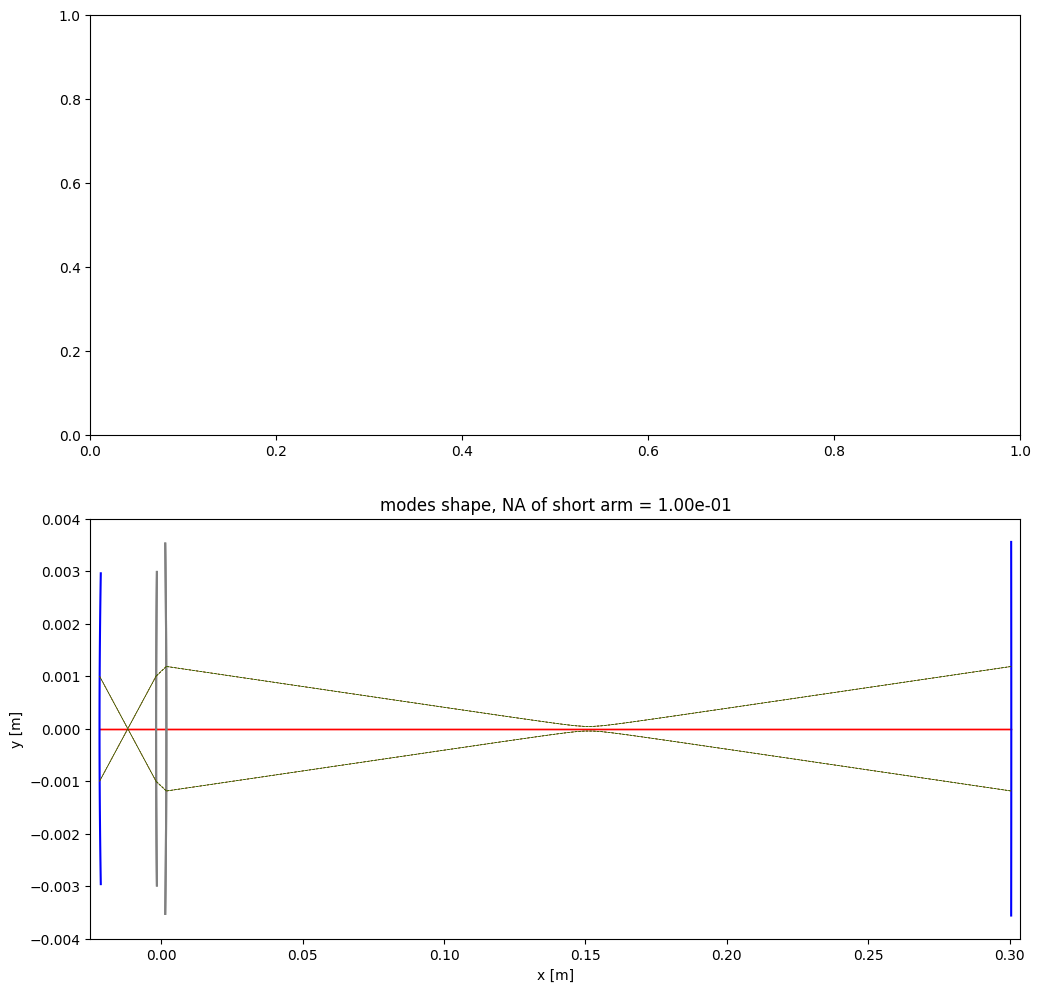

interactive(children=(Checkbox(value=False, description='print_parameters'), Dropdown(description='parameter',…

In [ ]:
with open('data/params_dict.pkl', 'rb') as f:
    params_dict = pkl.load(f)

params = params_dict['Sapphire, NA=0.1-0.039, L1=0.3 - High NA axis']
lambda_laser = 1064e-9


def f(print_parameters, element, parameter_index, shifts_max, shifts_n, shift_percentile_for_plotting, x_2, x_2_small_perturbation, axis_span, automatic_axis_span, camera_center):
    dim=2
    shifts_max = 10**shifts_max
    shifts_min = -shifts_max
    if print_parameters:
        print_parameters_func(locals())
    if automatic_axis_span:
        axis_span = None
    else:
        axis_span = 10**axis_span
    params_temp = params.copy()
    params_temp[1, 0] += (x_2 + x_2_small_perturbation)
    cavity = Cavity.from_params(params=params_temp, set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)    
    
    overlap_plot_shift_value = shifts_min * (1-shift_percentile_for_plotting) + shift_percentile_for_plotting * shifts_max
    shifts = np.linspace(shifts_min, shifts_max, int(shifts_n))
    overlaps, _ = cavity.calculated_shifted_cavity_overlap_integral((element, parameter_index), shifts)
    # print(np.stack([shifts, overlaps], axis=-1))
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))
    ax[0].plot(shifts, overlaps, label='overlap')
    ax[0].axvline(overlap_plot_shift_value, color='gray', linestyle='--', label='shift for gaussians overlap_plot')
    ax[0].legend()
    ax[0].set_xlabel("shift")
    ax[0].set_ylabel("overlap")
    ax[0].set_ylim(0.85, 1.01)
    ax[0].set_xlim(shifts_min, shifts_max)
    # tolerance = find_distance_to_first_crossing(shifts, overlaps)
    tolerance = cavity.calculate_parameter_critical_tolerance(parameter_index=(element, parameter_index),
                                                                                     initial_step=1e-6)
    ax[0].set_title(f"tolerance={tolerance:.2e}")
    ax[0].axvline(tolerance, linestyle='--', color='g')
    cavity.plot(dim=dim, axis_span=axis_span, camera_center=camera_center, ax=ax[1])
    
    ax[1].set_title(
        f"NA short arm = {cavity.arms[2].mode_parameters.NA[1]:.4f} NA long arm = {cavity.arms[0].mode_parameters.NA[0]:.4f}")
    ax[1].set_ylim(-0.004, 0.004)
    ax[1].set_title(f"modes shape, NA of short arm = {cavity.arms[2].mode_parameters.NA[0]:.2e}")
    perturbed_cavity = perturb_cavity(cavity=cavity, parameter_index=(element, parameter_index), shift_value = overlap_plot_shift_value)
    try:
        spot_size_lines = perturbed_cavity.generate_spot_size_lines(dim=dim)
        for line in spot_size_lines:
            ax[1].plot(line[0, :], line[1, :], color='green', linestyle='--', alpha=0.8, linewidth=0.5)
    except (FloatingPointError, AttributeError):
        pass
    plot_2_cavity_perturbation_overlap(cavity=cavity, parameter_index= (element, parameter_index), shift_value = overlap_plot_shift_value, ax=ax[2], axis_span=cavity.arms[0].mode_parameters.w_0[0] * 3)
    ax[2].set_xlabel("z")
    ax[2].set_ylabel("y")
    plt.show()
    winsound.Beep(880, 200)


max_shift_boundary = 1e-1
shifts_max = 1e-8
default_camera_center = -1
widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 parameter_index=widgets.Dropdown(value=0, options=[("x", 0), ('y', 1), ('t', 2), ('p', 3), ("r", 4), ("w", 5), ("n", 6)], description='parameter_index'),
                 element=widgets.Dropdown(options=[("Right Mirror", 0), ('Lens', 1), ('Left Mirror', 2)], value=0, description='parameter'),
                 shifts_max=FloatSlider(value=-5, min=-12, max=1, step=1e-9, description='shifts_max', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 shifts_n=FloatSlider(value=10, min=1, max=1000, step=1, description='shifts_n', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 shift_percentile_for_plotting=FloatSlider(value=0.5, min=0, max=1, step=0.0001, description='shift_percentile_for_plotting', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=-1e-2, max=0, step=1e-9, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_small_perturbation=FloatSlider(value=0, min=-1e-5, max=1e-5, step=1e-9, description='x_2_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 axis_span=FloatSlider(value=-0.45, min=-5, max=5, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 automatic_axis_span=widgets.Checkbox(value=True, description='automatic_axis_span', disabled=False),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_camera_center, description='Focus on mirror:',)
                 );

## Plot perturbation - for Presenting:

In [3]:
from matplotlib.lines import Line2D
with open('data/params_dict.pkl', 'rb') as f:
    params_dict = pkl.load(f)

params = params_dict['Sapphire, NA=0.1-0.039, L1=0.3 - High NA axis']
lambda_laser = 1064e-9
def mm_format(value, tick_number):
    return f"{value * 1e3:.2f}"


def cm_format(value, tick_number):
    return f"{value * 1e2:.2f}"

def f(print_parameters, element, parameter_index, shifts_max, shifts_n, shift_percentile_for_plotting, x_2, x_2_small_perturbation, axis_span, automatic_axis_span, camera_center):
    dim=2
    shifts_max = 10**shifts_max
    shifts_min = -shifts_max
    if print_parameters:
        print_parameters_func(locals())
    if automatic_axis_span:
        axis_span = None
    else:
        axis_span = 10**axis_span
    params_temp = params.copy()
    params_temp[1, 0] += (x_2 + x_2_small_perturbation)
    cavity = Cavity.from_params(params=params_temp, set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)    
    
    overlap_plot_shift_value = shifts_min * (1-shift_percentile_for_plotting) + shift_percentile_for_plotting * shifts_max
    shifts = np.linspace(shifts_min, shifts_max, int(shifts_n))
    overlaps, _ = cavity.calculated_shifted_cavity_overlap_integral((element, parameter_index), shifts)
    # print(np.stack([shifts, overlaps], axis=-1))
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    # tolerance = find_distance_to_first_crossing(shifts, overlaps)
    tolerance = cavity.calculate_parameter_critical_tolerance(parameter_index=(element, parameter_index),
                                                                                     initial_step=1e-6)
    cavity.plot(dim=dim, axis_span=axis_span, camera_center=camera_center, ax=ax[0])
    ax[0].set_title(
        f"The cavities and their modes shapes")
    ax[0].set_ylim(-0.004, 0.004)
    perturbed_cavity = perturb_cavity(cavity=cavity, parameter_index=(element, parameter_index), shift_value = overlap_plot_shift_value)
    try:
        spot_size_lines = perturbed_cavity.generate_spot_size_lines(dim=dim)
        for line in spot_size_lines:
            ax[0].plot(line[0, :], line[1, :], color='green', linestyle='--', alpha=0.8, linewidth=0.5, label="perturbed_mode")
    except (FloatingPointError, AttributeError):
        pass
    custom_lines = [Line2D([0], [0], color='red', linestyle='--', alpha=0.8, linewidth=0.5),
                Line2D([0], [0], color='green', linestyle='--', alpha=0.8, linewidth=0.5),
                   Line2D([0], [0], color="blue", linestyle=":", alpha=0.8, linewidth=0.5)]

    ax[0].legend(custom_lines, ['Unperturbed', 'Perturbed', 'Plane of overlap evaluation'])
    ax[0].axvline(cavity.arms[0].mode_parameters.center[0,0], 0, 1, color="blue", linestyle=":", alpha=0.8, linewidth=0.5)
    plot_2_cavity_perturbation_overlap(cavity=cavity, parameter_index= (element, parameter_index), shift_value = overlap_plot_shift_value, ax=ax[1], axis_span=cavity.arms[0].mode_parameters.w_0[0] * 3)
    overlap = np.abs(calculate_cavities_overlap_matrices(cavity, perturbed_cavity))**2
    ax[1].set_xlabel("z")
    ax[1].set_ylabel("y")
    ax[1].set_title(f"Modes amplitudes, overlap={overlap:.3f}")
    ax[0].set_ylim(-0.002, 0.002)
    ax[0].yaxis.set_major_formatter(plt.FuncFormatter(mm_format))
    ax[0].xaxis.set_major_formatter(plt.FuncFormatter(cm_format))
    ax[0].set_ylabel("y [mm]")
    ax[0].set_xlabel("x [cm]")
    ax[1].axes.ticklabel_format(style='sci')
    ax[1].yaxis.set_major_formatter(plt.FuncFormatter(mm_format))
    ax[1].xaxis.set_major_formatter(plt.FuncFormatter(mm_format))
    ax[1].set_ylabel("y [mm]")
    ax[1].set_xlabel("z [mm]")
    ax[1].legend(custom_lines, ['Unperturbed', 'Perturbed'])
    plt.suptitle(f"Right mirror transversal perturbation of {overlap_plot_shift_value:.2e}[m]")
    plt.savefig("figures\\mode_difference.png")
    plt.show()
    winsound.Beep(880, 200)
    


max_shift_boundary = 1e-1
shifts_max = 1e-8
default_camera_center = -1
widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 parameter_index=widgets.Dropdown(value=1, options=[("x", 0), ('y', 1), ('t', 2), ('p', 3), ("r", 4), ("w", 5), ("n", 6)], description='parameter_index'),
                 element=widgets.Dropdown(options=[("Right Mirror", 0), ('Lens', 1), ('Left Mirror', 2)], value=0, description='parameter'),
                 shifts_max=FloatSlider(value=-3.45, min=-12, max=1, step=1e-9, description='shifts_max', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 shifts_n=FloatSlider(value=10, min=1, max=1000, step=1, description='shifts_n', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 shift_percentile_for_plotting=FloatSlider(value=0.5546, min=0, max=1, step=0.0001, description='shift_percentile_for_plotting', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=-1e-2, max=0, step=1e-9, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_small_perturbation=FloatSlider(value=0, min=-1e-5, max=1e-5, step=1e-9, description='x_2_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 axis_span=FloatSlider(value=-0.45, min=-5, max=5, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 automatic_axis_span=widgets.Checkbox(value=True, description='automatic_axis_span', disabled=False),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_camera_center, description='Focus on mirror:',)
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Dropdown(description='parameter',…

# Control perturbations:

In [4]:
with open('data/params_dict.pkl', 'rb') as f:
    params_dict = pkl.load(f)

UNPERTURBED_PARAMS = params_dict['Sapphire, NA=0.2-0.0365, L1=0.3 - High NA axis']
lambda_laser = 1064e-9
dim=2


def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      x_1, x_1_small_perturbation, y_1, y_1_small_perturbation, t_1, r_1,
      y_2, t_2, p_2, r_2, w_2, n_in,
      x_3, x_3_small_perturbation, y_3, t_3, p_3, r_3, p_1, p_1_small_perturbation, x_2, x_2_small_perturbation,
      auto_set_x, x_span, auto_set_y, y_span, camera_center,
      savefig):

    if print_parameters:
        print_parameters_func(locals())

    x_span = 10 ** x_span
    y_span = 10 ** y_span
    
    x_1 += x_1_small_perturbation
    x_3 += x_3_small_perturbation
    y_1 += y_1_small_perturbation
    p_1 += p_1_small_perturbation
    x_2 += x_2_small_perturbation

    perturbed_params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [x_2, y_2, t_2, p_2, r_2, n_in, w_2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).astype('complex128')

    perturbed_params += UNPERTURBED_PARAMS
    
    unperturbed_cavity = Cavity.from_params(params=UNPERTURBED_PARAMS, set_initial_surface=False, standing_wave=True,
                                lambda_laser=lambda_laser, p_is_trivial=True, t_is_trivial=True)
    
    p_is_trivial = y_1 == 0 and y_2 == 0 and y_3 == 0 and p_1 == 0 and p_2 == 0 and p_3 == 0
    t_is_trivial = t_1 == 0 and t_2 == 0 and t_3 == 0
    
    perturbed_cavity = Cavity.from_params(params=perturbed_params, set_initial_surface=False, standing_wave=True,
                                lambda_laser=lambda_laser, p_is_trivial=p_is_trivial, t_is_trivial=t_is_trivial)

    fig, ax = plt.subplots(2, 1, figsize=(16, 12))

    unperturbed_cavity.plot(dim=dim, axis_span=x_span, camera_center=camera_center, ax=ax[0])
    try:
        spot_size_lines = perturbed_cavity.generate_spot_size_lines(dim=dim)
        for line in spot_size_lines:
            ax[0].plot(line[0, :], line[1, :], color='green', linestyle='--', alpha=0.8, linewidth=0.5)
    except (FloatingPointError, AttributeError):
        pass

    overlap = calculate_cavities_overlap_matrices(cavity_1=unperturbed_cavity, cavity_2=perturbed_cavity)
    ax[0].set_title(f"original mode-perturbed mode overlap: {np.abs(overlap):.5f}\nNA short arm = {perturbed_cavity.arms[2].mode_parameters.NA[1]:.4f}\nshort arm waist axial displacement = {perturbed_cavity.arms[2].mode_parameters.center[0, 0] - unperturbed_cavity.arms[2].mode_parameters.center[0, 0]:.5e}", pad=10)
    ax[0].grid()
    if auto_set_x:
        cavity_length = UNPERTURBED_PARAMS[0, 0] - UNPERTURBED_PARAMS[2, 0]
        ax[0].set_xlim(UNPERTURBED_PARAMS[2, 0] - 0.01 * cavity_length, UNPERTURBED_PARAMS[0, 0] + 0.01 * cavity_length)
    if auto_set_y:
        y_lim = maximal_lens_height(UNPERTURBED_PARAMS[1, INDICES_DICT['r']], UNPERTURBED_PARAMS[1, INDICES_DICT['w']]) * 1.1
    else:
        y_lim = y_span
    ax[0].set_ylim(-y_lim, y_lim)
    plot_2_cavity_perturbation_overlap(cavity=unperturbed_cavity, second_cavity=perturbed_cavity, ax=ax[1], axis_span=unperturbed_cavity.arms[0].mode_parameters.w_0[0] * 3)
    
    if savefig:
        plt.savefig(f"figures/systems/{int(time())} {title_a} {title_b}.svg")

small_boundary = 1e-6
medium_boundary = 1e-3
big_boundary = 1
dx = 1e-10
dt_max = 200
dtheta_max = 100

default_axis_span = 0.01
default_lambda_laser = 1064e-09
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.00
default_dim = 2
default_set_initial_surface = False
default_camera_center = -1

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=0, min=-big_boundary, max=big_boundary, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1_small_perturbation=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='y_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=0, min=-1e-2, max=5e-2, step=1e-9, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, descripttion='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, descrstep=1e-10, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_2=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=dx, description='w_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_in=FloatSlider(value=0, min=-big_boundary, max=big_boundary, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=0, min=-big_boundary, max=big_boundary, step=1e-9, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 x_3_small_perturbation=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=1e-9, description='x_3_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=1e-9, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1_small_perturbation=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='p_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=-medium_boundary, max=medium_boundary, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_small_perturbation=FloatSlider(value=0, min=-small_boundary, max=small_boundary, step=dx, description='x_2_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_x=widgets.Checkbox(value=True, description='Auto set x', disabled=False),
                 x_span=FloatSlider(value=-1, min=-5, max=1.3, step=0.01, description='x span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_y=widgets.Checkbox(value=True, description='Auto set y', disabled=False),
                 y_span=FloatSlider(value=-2.9, min=-4, max=-2, step=0.01, description='y span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=2, description='Focus on mirror:',),
                 savefig=widgets.Checkbox(value=False, description='save image', disabled=False),
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# Set ups exploration:

In [6]:
# font = {'size'   : 22}
# rc('font', **font)

def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      x_1, x_1_small_perturbation, y_1, t_1, p_1, r_1,
      x_2, x_2_small_perturbation, y_2, t_2, p_2, r_2, w_2, n_out, n_in,
      x_3, x_3_small_perturbation, y_3, t_3, p_3, r_3,
      lambda_laser, power_laser, 
      elev, azim, axis_span, automatic_axis_span, camera_center,even_axes, 
      dim, savefig):
    if print_default_parameters:
        print(f"default_x_1 = {x_1+x_1_small_perturbation:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2+x_2_small_perturbation:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_r_2 = {r_2:.10e}\ndefault_w_2 = {w_2:.10e}\ndefault_x_3 = {x_3+x_3_small_perturbation:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_camera_center = {camera_center}\ndefault_n_out = {n_out}\ndefault_n_in = {n_in}")   
        
    
    if automatic_axis_span:
        axis_span = None
    else:
        axis_span = 10**axis_span
    # if print_parameters:
        # print_parameters_func(locals())
    
    x_1 += x_1_small_perturbation
    x_3 += x_3_small_perturbation
    x_2 += x_2_small_perturbation

    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, *PHYSICAL_SIZES_DICT['thermal_properties_fused_silica'].to_array, 0],
                       [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, *PHYSICAL_SIZES_DICT['thermal_properties_fused_silica'].to_array, 1],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, *PHYSICAL_SIZES_DICT['thermal_properties_fused_silica'].to_array, 0]])
    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser, power=power_laser)
    unheated_cavity = cavity.thermal_transformation()
    if print_parameters:
        print(f"{params=}")
    if dim == 2:
        fig, ax = plt.subplots(2, 1, figsize=(16, 12))
    else:
        fig = plt.figure()
        ax = [1, 1]
        ax[0] = fig.add_subplot(211, projection='3d')
        ax[0].view_init(elev=elev, azim=azim)
        ax[1] = fig.add_subplot(221, projection='3d')
        ax[1].view_init(elev=elev, azim=azim)
        
    ax[1] = cavity.plot(dim=dim, axis_span=axis_span, camera_center=camera_center, ax=ax[1])


    title_a =  f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.2e} [m]"
    title_b = f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e}, long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} [m]"
    ax[1].set_title(f"{title_a}\n{title_b}", pad=10)
    if even_axes:
        ax[1].axis('equal')
        # ax[1].set_ylim(-0.01, 0.01)
    else:
        ax[1].set_ylim(-0.002, 0.002)
        
    unheated_cavity.plot(dim=dim, ax=ax[0])
    ax[0].set_xlim(ax[1].get_xlim())
    if even_axes:
        ax[0].axis('equal')
    else:
        ax[0].set_ylim(ax[1].get_ylim())
    ax[0].set_title(f"unheatet_cavity, short arm NA={unheated_cavity.arms[2].mode_parameters.NA[0]:.2e}")
    
    if savefig:
        plt.savefig(f"figures/systems/{int(time())} {title_a} {title_b}.svg")
    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.00001
dt_max = 200
dtheta_max = 100

params=np.array([[ 2.7424349948e-01+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  1.3688702599e-01+0.j,  0.0000000000e+00+0.j,
         0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  1.0000000000e+00+0.j,  4.8000000000e-07+0.j,  1.0000000000e-06+0.j,
         1.3800000000e+00+0.j,  1.2000000000e-05+0.j,  1.5000000000e-01+0.j,  0.0000000000e+00+0.j],
       [ 1.7347234760e-18+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+1.j,  1.4454397707e-02+0.j,  1.7600000000e+00+0.j,
         1.0000000000e-03+0.j,  1.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  5.5000000000e-06+0.j,  1.0000000000e-06+0.j,
         4.6060000000e+01+0.j,  1.1700000000e-05+0.j,  3.0000000000e-01+0.j,  1.0000000000e+00+0.j],
       [-2.0500000000e-02+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j, -0.0000000000e+00-1.j,  1.0000007169e-02+0.j,  0.0000000000e+00+0.j,
         0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  1.0000000000e+00+0.j,  4.8000000000e-07+0.j,  1.0000000000e-06+0.j,
         1.3800000000e+00+0.j,  1.2000000000e-05+0.j,  1.5000000000e-01+0.j,  0.0000000000e+00+0.j]])
default_x_1 = params[0, 0]
default_y_1 = params[0, 1]
default_t_1 = np.real(params[0, 2]) + np.pi * np.imag(params[0, 2])
default_p_1 = np.real(params[0, 3]) + np.pi * np.imag(params[0, 3])
default_r_1 = params[0, 4]

default_x_2 = params[1, 0]
default_y_2 = params[1, 1]
default_t_2 = np.real(params[1, 2]) + np.pi * np.imag(params[1, 2])
default_p_2 = np.real(params[1, 3]) + np.pi * np.imag(params[1, 3])
default_r_2 = params[1, 4]
default_n_in = params[1, 5]
default_w_2 = params[1, 6]
default_n_out = params[1, 7]

default_x_3 = params[2, 0]
default_y_3 = params[2, 1]
default_t_3 = np.real(params[2, 2]) + np.pi * np.imag(params[2, 2])
default_p_3 = np.real(params[2, 3]) + np.pi * np.imag(params[2, 3])
default_r_3 = params[2, 4]
default_axis_span = 0.01
default_lambda_laser = 10.64e-07
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.00
default_dim = 2
default_set_initial_surface = False
default_camera_center = -1

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=-r_max, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=0, min=-1e-3, max=1e-3, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=default_t_1-1e-5, max=default_t_1+1e-5, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=default_p_1-1e-5, max=default_p_1+1e-5, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=default_r_1*0.8, max=default_r_1*1.3, step=1e-9, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=-1e-2, max=1e-2, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_small_perturbation=FloatSlider(value=0, min=-1e-5, max=1e-5, step=1e-9, description='x_2_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=0, min=-1e-11, max=1e-11, step=1e-14, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=default_t_2-1e-5, max=default_t_2+1e-5, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=default_p_2-1e-5, max=default_p_2+1e-5, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=default_r_2, min=default_r_2*0.8, max=default_r_2*1.3, step=1e-10, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_2=FloatSlider(value=default_w_2, min=3e-4, max=1e-2, step=dx, description='w_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_out=FloatSlider(value=default_n_out, min=1, max=2, step=dx, description='n_out', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_in=FloatSlider(value=default_n_in, min=1, max=2, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=-1, max=r_max, step=1e-9, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 x_3_small_perturbation=FloatSlider(value=0, min=-2e-4, max=2e-4, step=1e-9, description='x_3_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=default_t_3-1e-5, max=default_t_3+1e-5, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=default_p_3-1e-5, max=default_p_3+1e-5, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=default_r_3*0.8, max=default_r_3*1.3, step=1e-9, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 power_laser=FloatSlider(value=50000, min=0, max=100000, step=1e2, description='power laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=-0.45, min=-5, max=5, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 automatic_axis_span=widgets.Checkbox(value=True, description='automatic_axis_span', disabled=False),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_camera_center, description='Focus on mirror:',),
                 even_axes=widgets.Checkbox(value=False, description='even_axes', disabled=False),
                 savefig=widgets.Checkbox(value=False, description='save image', disabled=False),
                 );

c:\users\mkali\appdata\local\programs\python\python39\lib\site-packages\traitlets\traitlets.py:2100: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# Automatic finding of a lens for given two modes:

In [7]:
lambda_laser = 1.064e-6
NA_2 = 0.003
z_R_2 = lambda_laser / (np.pi * NA_2**2)
L_1 = 0.01
NA_1 = 0.1
z_R_1 = lambda_laser / (np.pi * NA_1**2)
mode_1_center = np.array([0, 0, 0])
mode_1_k_vector = np.array([1, 0, 0])
mode_2_x = 0.1
mode_1 = ModeParameters(center=np.stack([mode_1_center, mode_1_center], axis=0), k_vector=mode_1_k_vector, z_R=np.array([z_R_1, z_R_1]),
                        principle_axes=np.array([[0, 0, 1], [0, 1, 0]]), lambda_laser=lambda_laser)
mirror_1 = match_a_mirror_to_mode(mode_1, -L_1 / 2)
local_mode_1 = mode_1.local_mode_parameters(L_1 / 2)
desired_local_mode_2 = LocalModeParameters(z_minus_z_0=mode_2_x, z_R=z_R_2)
lens_parameters, local_mode_2 = match_a_lens_parameters_to_modes(local_mode_1,
                                                                 local_mode_2=desired_local_mode_2,
                                                                 fixed_n_lens=1.5, fix_z_2=False)
R, w, n = lens_parameters
params = np.array([L_1 / 2 + w / 2, 0, 0, 0, R, n, w, 1, 0, 0, 1])
surface_1, surface_2 = generate_lens_from_params(params)
L_2 = np.abs(2 * local_mode_2.z_minus_z_0[0])
lens_second_center = mode_1_center + mode_1_k_vector*L_1 / 2 + lens_parameters[1] * mode_1_k_vector
mode_2 = local_mode_2.to_mode_parameters(location_of_local_mode_parameter=lens_second_center,
                                         k_vector=mode_1_k_vector, lambda_laser=lambda_laser)
mirror_3 = match_a_mirror_to_mode(mode_2, np.abs(local_mode_2.z_minus_z_0[0])+0.1)
cavity = Cavity([mirror_1, surface_1, surface_2, mirror_3],
                lambda_laser=lambda_laser,
                standing_wave=True,
                p_is_trivial=True,
                t_is_trivial=True,
                set_mode_parameters=True,
                names=['Left mirror', 'Lens_left', 'lens_right', 'Right mirror'])
cavity.plot()
plt.axvline(lens_second_center[0], color='k', linestyle='--')
plt.grid()
plt.show()

TypeError: match_a_mirror_to_mode() missing 1 required positional argument: 'thermal_properties'

# Alexey's dummy cavity

In [16]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      x_1, y_1, t_1, p_1, r_1,
      x_2, y_2, t_2, p_2, r_2,
      x_3, y_3, t_3, p_3, r_3,
      lambda_laser,
      elev, azim, axis_span, focus_point,
      set_initial_surface, dim):
    
    if print_parameters:
        print_parameters_func(locals())
        
    if print_default_parameters:
        print(f"default_x_1 = {x_1=:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_r_2 = {r_2:.10e}\ndefault_x_3 = {x_3:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_focus_point = {focus_point}")   
    y_1 += 0
    t_1 += 0
    p_1 += 0
    x_2 += 0
    y_2 += 0
    t_2 += 0
    p_2 += 5 * np.pi / 4
    x_3 += 0
    y_3 += 0
    t_3 += 0
    p_3 += np.pi / 2

    params = np.array([[x_1, y_1, 0, t_1, p_1, r_1],
                       [x_2, y_2, 0, t_2, p_2, r_2],
                       [x_3, y_3, 0, t_3, p_3, r_3]])

    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True, lambda_laser=lambda_laser)
    # cavity.find_central_line()
    central_line = cavity.trace_ray(cavity.default_initial_ray)
    for i, arm in enumerate(cavity.arms):
        arm.central_line = central_line[i]
    cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()
    
    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    
    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    ax.set_title(f"NA_out of plane = {cavity.arms[0].mode_parameters.NA[0]:.2e} , NA_in plane = {cavity.arms[0].mode_parameters.NA[1]:.2e}")
    
    for mirror in cavity.mirrors:
        ax.plot(mirror.origin[0], mirror.origin[1], 'ro')
    
    if print_mathematica_parameters:
        print(f"r_1={{{cavity.mirrors[0].origin[0]:.5f}, {cavity.mirrors[0].origin[1]:.5f}, 0}}\nR_1={cavity.mirrors[0].radius:.5f}\nr_2={{{cavity.mirrors[1].origin[0]:.5f}, {cavity.mirrors[1].origin[1]:.5f}, 0}}\nR_2={cavity.mirrors[1].radius:.5f}\nr_3={{{cavity.mirrors[2].origin[0]:.5f}, {cavity.mirrors[2].origin[1]:.5f}, 0}}\nR_3={cavity.mirrors[2].radius:.5f}")
    
    # plt.show()
    fig_2, ax_2 = plt.subplots(2, 1)
    shifts_r_1 = np.linspace(0, 0.02, 100)
    overlaps_r_1 = cavity.calculated_shifted_cavity_overlap_integral((0, 5), shifts_r_1)

    shifts_p_1 = np.linspace(0, 0.02, 100)
    overlaps_p_1 = cavity.calculated_shifted_cavity_overlap_integral((0, 4), shifts_p_1)

    ax_2[0].plot(shifts_r_1, overlaps_r_1, label="r_1 stability")
    ax_2[1].plot(shifts_p_1, overlaps_p_1, label="p_1 stability")
    ax_2[0].legend()
    ax_2[1].legend()
    # plt.show()
 
    
    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.00001
dt_max = 200
dtheta_max = 100

default_x_1 = x_1=6.000e-01
default_y_1 = 0.000e+00
default_t_1 = 0.000e+00
default_p_1 = 0.000e+00
default_r_1 = 4.000e-01
default_x_2 = 0.000e+00
default_y_2 = 0.000e+00
default_t_2 = 0.000e+00
default_p_2 = 0.000e+00
default_r_2 = 4.070e-01
default_x_3 = 0.000e+00
default_y_3 = 6.000e-01
default_t_3 = 0.000e+00
default_p_3 = 0.000e+00
default_r_3 = 4.000e-01
default_lambda_laser = 10.64e-07
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.87
default_dim = 2
default_set_initial_surface = False
default_focus_point = -1

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=r_min, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=default_x_2, min=r_min, max=r_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=default_y_2, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=default_r_2, min=r_min, max=r_max, step=dx, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=r_min, max=r_max, step=dx, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Calculated surface", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# Symmetric 2 mirrors and one lens - Low NA:

In [5]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      lambda_laser, elev, azim, axis_span, focus_point, set_initial_surface, dim, n_out, n_in,
      x_1, x_1_small_perturbation, y_1, t_1, p_1, r_1,
      x_2, y_2, t_2, p_2, f_2, w_2,
      x_3, y_3, t_3, p_3, r_3,
      ):

    if print_parameters:
        print_parameters_func(locals())

    if print_default_parameters:
        print(f"default_x_1 = {x_1:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_f_2 = {f_2:.10e}\ndefault_w_2 = {w_2:.10e}\ndefault_x_3 = {x_3:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_focus_point = {focus_point}")   
    x_1 += x_1_small_perturbation
    y_1 += 0
    t_1 += 0
    p_1 += 0
    x_2 += 0
    y_2 += 0
    t_2 += 0
    p_2 += np.pi
    x_3 += 0
    y_3 += 0
    t_3 += 0
    p_3 += np.pi
    r_2 = 2 * (n_in - n_out) * f_2

    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                       [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])

    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)
    cavity.find_central_line()
    # central_line = cavity.trace_ray(cavity.default_initial_ray)
    # for i, arm in enumerate(cavity.arms):
        # arm.central_line = central_line[i]
    # cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    # ax.set_xlim(- axis_span, axis_span)
    # ax.set_ylim(-0.0025, 0.0025)
    
    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    ax.set_title(
            f"NA right arm = {cavity.arms[0].mode_parameters.NA[0]:.10e} x_R right arm = {cavity.arms[0].mode_parameters.z_R[0]:.10e} \n"
            f"NA left arm = {cavity.arms[2].mode_parameters.NA[1]:.10e} x_R left arm = {cavity.arms[2].mode_parameters.z_R[1]:.10e}\n"
            f"x_Rs ratio={cavity.arms[0].mode_parameters.z_R[1] / cavity.arms[2].mode_parameters.z_R[1]:.10e}")    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.00001
dt_max = 200
dtheta_max = 100

default_x_1 = 1.000e-01
default_x_1_small_perturbation=0
default_y_1 = 0.000e+00
default_t_1 = 0.000e+00
default_p_1 = 0.000e+00
default_r_1 = 7.000e-02
default_x_2 = 0.000e+00
default_y_2 = 0.000e+00
default_t_2 = 0.000e+00
default_p_2 = 0.000e+00
default_f_2 = 3.500e-02
default_w_2 = 1.000e-03
default_x_3 = -1.000e-01
default_y_3 = 0.000e+00
default_t_3 = 0.000e+00
default_p_3 = 0.000e+00
default_r_3 = 7.000e-02
default_lambda_laser = 10.64e-07
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.13
default_dim = 2
default_set_initial_surface = False
default_focus_point = -1
default_n_out=1
default_n_in=1.5

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Calculated surface", 3)], value=default_focus_point, description='Focus on mirror:',),
                 n_out=FloatSlider(value=default_n_out, min=1, max=2, step=dx, description='n_out', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_in=FloatSlider(value=default_n_in, min=1, max=2, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1=FloatSlider(value=default_x_1, min=-r_max, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=default_x_1_small_perturbation, min=-1e-4, max=1e-4, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=default_x_2, min=r_min, max=r_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=default_y_2, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 f_2=FloatSlider(value=default_f_2, min=r_min, max=r_max, step=dx, description='f_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_2=FloatSlider(value=default_w_2, min=r_min, max=r_max, step=dx, description='w_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=-r_max, max=r_max, step=dx, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# not-symmetric two cavities and an ideal lens - smart choice of parameters:

In [9]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      x_1, x_1_small_perturbation, y_1, t_1, p_1, r_1,
      x_2, y_2, t_2, p_2, f_2,
      x_3, x_3_small_perturbation, y_3, t_3, p_3, r_3,
      lambda_laser,
      elev, azim, axis_span, focus_point,
      set_initial_surface, dim):

    if print_parameters:
        print_parameters_func(locals())

    if print_default_parameters:
        print(f"default_x_1 = {x_1:.10e}\ndefault_x_1_small_perturbation = {default_x_1_small_perturbation:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_f_2 = {f_2:.10e}\ndefault_x_3 = {x_3:.10e}\ndefault_x_3_small_perturbation = {default_x_3_small_perturbation:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_focus_point = {focus_point}\ndefault_f_2={f_2:.10e}")   
    x_1 += x_1_small_perturbation
    p_2 += np.pi
    x_3 += x_3_small_perturbation
    p_3 += np.pi

    mirror_1 = Surface.from_params(np.array([x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
    mirror_3 = Surface.from_params(np.array([x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0, 0, 0, 0]))

    ideal_lens = IdealLens(outwards_normal=unit_vector_of_angles(t_2, p_2), center=np.array([x_2, y_2, 0]),
                           focal_length=f_2)

    cavity = Cavity([mirror_1, ideal_lens, mirror_3], set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser,
                    t_is_trivial=True, p_is_trivial=True)
    # cavity.find_central_line()
    cavity.plot()
    central_line = cavity.trace_ray(cavity.default_initial_ray)
    for i, arm in enumerate(cavity.arms):
        arm.central_line = central_line[i]
    cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    # ax.set_xlim(- axis_span, axis_span)
    # ax.set_ylim(-0.0025, 0.0025)

    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    ax.set_title(
        f"NA right arm = {cavity.arms[0].mode_parameters.NA[0]:.10e} x_R right arm = {cavity.arms[0].mode_parameters.z_R[0]:.10e} \n"
        f"NA left arm = {cavity.arms[2].mode_parameters.NA[1]:.10e} x_R left arm = {cavity.arms[2].mode_parameters.z_R[1]:.10e}\n"
        f"x_Rs ratio={cavity.arms[0].mode_parameters.z_R[1] / cavity.arms[2].mode_parameters.z_R[1]:.10e}")
    ax.set_xlim(1.2 * x_3, -2 * x_3)
    ax.set_ylim(-0.015, 0.015)

    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.000001
dt_max = 200
dtheta_max = 100

NA_2 = 5e-02
NA_1 = 5e-03
L_2 = 0.01
λ = 1064e-9

x_R2 = λ / (np.pi * NA_2**2)
R_3 = L_2 / 2 + x_R2**2 / (L_2 / 2)
R_22 = R_3
w_22 = NA_2 * x_R2 * np.sqrt(1+(L_2 / (2*x_R2))**2)
w_21 = w_22
x_R1 = λ / (np.pi * NA_1**2)
w_01 = λ / (np.pi * NA_1)
L_1 = 2*x_R1 * np.sqrt((w_21 / w_01)**2 - 1)
R_21 = L_1 / 2 + 2*x_R1**2 / L_1
R_1 = R_21
f_2 = R_21 * R_22 / (R_21 + R_22)

default_x_1 = L_1
default_x_1_small_perturbation = 0.000000e+00
default_y_1 = 0.000000e+00
default_t_1 = 0.000000e+00
default_p_1 = 0.000000e+00
default_r_1 = R_1
default_x_2 = 0.000000e+00
default_y_2 = 0.000000e+00
default_t_2 = 0.000000e+00
default_p_2 = 0.000000e+00
default_f_2 = f_2
default_x_3 = - L_2
default_x_3_small_perturbation = -4.857000e-04
default_y_3 = 0.000000e+00
default_t_3 = 0.000000e+00
default_p_3 = 0.000000e+00
default_r_3 = R_3
default_lambda_laser = λ
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.00
default_dim = 2
default_set_initial_surface = False
default_focus_point = 3
widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=default_x_1-0.1, max=default_x_1+0.1, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.8e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=default_x_1_small_perturbation, min=-1e-4, max=1e-4, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=default_r_1-0.1, max=default_r_1+0.1, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=default_x_2, min=r_min, max=r_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=default_y_2, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 f_2=FloatSlider(value=default_f_2, min=default_f_2-0.1, max=default_f_2+0.1, step=dx, description='f_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=default_x_3-0.1, max=default_x_3+0.1, step=1e-5, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 x_3_small_perturbation=FloatSlider(value=default_x_3_small_perturbation, min=-dx, max=5e-4, step=1e-9, description='x_3_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=default_r_3-0.1, max=default_r_3+0.1, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );







interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# Two mirros cavity

In [19]:
def f(print_parameters,
      x_1, x_1_b, x_1_c, y_1, t_1, p_1, r_1, r_1_b, r_1_c,
      x_3, y_3, t_3, p_3,
      lambda_laser, axis_span, focus_point, dim):
    
    
    if print_parameters:
        print(f"{x_1=:.10e}\n{x_1_b=:.10e}\n{x_1_c=:.10e}\n{y_1=:.10e}\n{t_1=:.10e}\n{p_1=:.10e}\n{r_1=:.10e}\n{x_3=:.10e}\n{y_3=:.10e}\n{t_3=:.10e}\n{p_3=:.10e}\n{lambda_laser=:.10e}")
    x_1 += x_1_b
    x_1 += x_1_c
    r_1 += r_1_b
    r_1 += r_1_c
    r_3 = r_1
    p_3 += np.pi

    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])

    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)
    # cavity.find_central_line()
    central_line = cavity.trace_ray(cavity.default_initial_ray)
    for i, arm in enumerate(cavity.arms):
        arm.central_line = central_line[i]
    cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    L = (x_1 - x_3)
    g_1 = 1 - L / r_1
    g_2 = 1 - L / r_3
    theoretical_x_R = np.sqrt(g_1 * g_2 * (1-g_1 * g_2) / (g_1 + g_2 - 2 * g_1 * g_2)**2) * L
    theoretical_x_R_2 = L / 2 * np.sqrt(2 * r_1 / L - 1)
    # print(theoretical_x_R_2)
    theoretical_NA = np.sqrt(lambda_laser / (np.pi * theoretical_x_R))
    ax.set_title(
        f"NA = {cavity.arms[0].mode_parameters.NA[0]:.4f} x_R = {cavity.arms[0].mode_parameters.z_R[0]:.10e}\n NA theoretical = {theoretical_NA:.4f} x_R theoretical = {theoretical_x_R}\n x_Rs ratio={cavity.arms[0].mode_parameters.z_R[1] / theoretical_x_R:.10e}")

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.000001
dt_max = 200
dtheta_max = 100

λ = 1064e-9



default_x_1 = 0.05
default_x_1_b = 0.000000e+00
default_y_1 = 0.000000e+00
default_t_1 = 0.000000e+00
default_p_1 = 0.000000e+00
default_r_1 = 0.2
default_x_3 = - 0.05
default_y_3 = 0.000000e+00
default_t_3 = 0.000000e+00
default_p_3 = 0.000000e+00
default_r_3 = 0.2
default_lambda_laser = λ
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.5
default_dim = 2
default_set_initial_surface = False
default_focus_point = -1

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=-r_max, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_b=FloatSlider(value=default_x_1_b, min=-1e-2, max=1e-2, step=1e-9, description='x_1_b', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_c=FloatSlider(value=default_x_1_b, min=-1e-4, max=1e-4, step=1e-9, description='x_1_c', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1_b=FloatSlider(value=0, min=-1e-3, max=1e-3, step=1e-6, description='r_1_b', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1_c=FloatSlider(value=0, min=-1e-6, max=1e-6, step=1e-9, description='r_1_c', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=-r_max, max=r_max, step=1e-5, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # r_3=FloatSlider(value=default_r_3, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );







interactive(children=(Checkbox(value=False, description='print_parameters'), FloatSlider(value=0.05, descripti…

# Specific setups:

## High NA ratio set-up

In [7]:
# HIGH NA ratio - diverging to the right:



# HIGH NA - converging to the right:

x_1 = 0.63752
y_1 = 0.0000000000e+00
t_1 = 0.0000000000e+00
p_1 = 0.0000000000e+00
r_1 = 6.6409000000e-01
x_2 = 0.0000000000e+00
y_2 = 0.0000000000e+00
t_2 = 0.0000000000e+00
p_2 = 0.0000000000e+00
r_2 = 5.6600000000e-03
w_2 = 1.0000000000e-03
n_in = 1.5000000000e+00
n_out = 1.0000000000e+00
x_3 = -1.0953903000e-02
y_3 = 0.0000000000e+00
t_3 = 0.0000000000e+00
p_3 = 0.0000000000e+00
r_3 = 5.0000000000e-03
axis_span = 0.005
camera_center = 2
lambda_laser = 1064e-9
names = ['Right Mirror', 'lens', 'Left Mirror']

p_2 += np.pi
p_3 += np.pi

params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                   [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                   [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])
# ratios = 1 - np.concatenate((np.array([0]), np.logspace(-7, -3, 5, endpoint=True)))
# x_1_values = x_1 * ratios
x_1_values = np.linspace(x_1, 0.2, 5)
params_temp = params.copy()
params_temp[0, 0] = x_1_values[1]
cavity = Cavity.from_params(params=params_temp, standing_wave=True,
                            lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)
fig, ax = plt.subplots(figsize=(13, 5))
cavity.plot(axis_span=0.05, camera_center=camera_center, ax=ax)
ax.set_xlim(x_3 - 0.01, x_1 + 0.01)
ax.set_ylim(-0.002, 0.002)
ax.set_title(
    f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.2e}\n"
    f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e}, long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e}")
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.savefig('figures/systems/mirror-lens-mirror_high_NA_ratio.png', dpi=300, bbox_inches='tight')
plt.show()
# %%
NAs, tolerance_matrix, cavities = generate_tolerance_of_NA(params, parameter_index_for_NA_control=(0, 0),
                                                           arm_index_for_NA=2, parameter_values=x_1_values,
                                                           t_is_trivial=True, p_is_trivial=True,
                                                           return_cavities=True, lambda_laser=lambda_laser)
# %%
for i in range(len(x_1_values)):
    overlaps_series = cavities[i].generate_overlap_series(shifts=2 * np.abs(tolerance_matrix[:, :, i]),
                                                          shift_size=100,
                                                          print_progress=True)
    cavities[i].generate_overlaps_graphs(overlap_threshold=0.9, arm_index_for_NA=2,
                                         overlaps_series=overlaps_series,
                                         tolerance_matrix=tolerance_matrix[:, :, i], names=names)
    plt.suptitle(
        f"short arm NA={cavities[i].arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavities[i].surfaces[2].center - cavities[i].surfaces[3].center):.2e}\n"
        f"long arm NA={cavities[i].arms[0].mode_parameters.NA[0]:.2e}, long arm length = {np.linalg.norm(cavities[i].surfaces[1].center - cavities[i].surfaces[0].center):.2e}")
    plt.savefig(
        f'figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_overlaps_NA={cavities[i].arms[2].mode_parameters.NA[0]:.2e}.png',
        dpi=300, bbox_inches='tight')
    plt.show()
# %%
ax = plot_tolerance_of_NA_same_plot(NAs=NAs, tolerance_matrix=tolerance_matrix, names=names)
ax.legend(loc='upper right')
plt.savefig('figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_tolerances_log.png', dpi=300,
            bbox_inches='tight')
plt.show()

ValueError: not enough values to unpack (expected 17, got 11)

## Fabry Perot

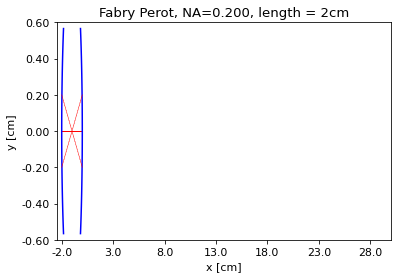

In [8]:
# %%
x_1 = 2.0000000000e-02
y_1 = 0.0000000000e+00
t_1 = 0.0000000000e+00
p_1 = 0.0000000000e+00
r_1 = 1.00000071e-02
x_3 = 0
y_3 = 0.0000000000e+00
t_3 = 0.0000000000e+00
p_3 = 0.0000000000e+00
lambda_laser = 1064e-09
r_3 = r_1
p_3 += np.pi
names = ['Right Mirror', 'Left Mirror']
# INDICES_DICT = {'x': 0, 'y': 1, 't': 2, 'p': 3, 'r': 4, 'n_1': 5, 'w': 6, 'n_2': 7, 'z': 8, 'curvature_sign': 9,
#                 'alpha_thermal_expansion': 10, 'beta_power_absorption': 11, 'kappa_thermal_conductivity': 12,
#                 'dn_dT': 13,
#                 'nu_poisson_ratio': 14, 'alpha_volume_absorption': 15, 'surface_type': 16}
params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, *PHYSICAL_SIZES_DICT['thermal_properties_ULE'].to_array, 0],
                   # [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                   [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, *PHYSICAL_SIZES_DICT['thermal_properties_ULE'].to_array, 0]])
ratios = 1 - np.concatenate((np.array([0]), np.logspace(-7, -3.5, 10, endpoint=True)))
x_1_values = x_1 * ratios
params_temp = params.copy()
params_temp[0, 0] = x_1_values[0]

cavity = Cavity.from_params(params=params_temp, standing_wave=True,
                            lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)
font = {'size': 11}
rc('font', **font)
fig, ax = plt.subplots(figsize=(6, 4))
cavity.plot(axis_span=1, ax=ax)
ax.set_xlim(-0.005, 0.3205)
length = x_1 - x_3 + 0.002
ax.set_ylim(-0.006, 0.006)

def cm_format_shifted(value, tick_number):
    return f"{value * 1e2 - 2:.1f}"
ax.yaxis.set_major_formatter(plt.FuncFormatter(cm_format))
ax.xaxis.set_major_formatter(plt.FuncFormatter(cm_format_shifted))
ax.set_ylabel("y [cm]")
ax.set_xlabel("x [cm]")
ax.set_title(
    f"Fabry Perot, NA={cavity.arms[0].mode_parameters.NA[0]:.3f}, length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center)*100:.0f}cm")

plt.savefig('figures/systems/Fabry-Perot_scaled_x.svg', dpi=300, bbox_inches='tight')
plt.show()

# Plotting scripts:

### Simple plot of a single cavity:

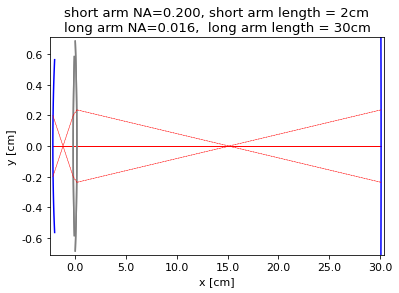

In [9]:
    # %%
    # Load data/params_dict.pkl:
    font = {'size': 11}
    rc('font', **font)
    with open('data/params_dict.pkl', 'rb') as f:
        params_dict = pkl.load(f)
    params = params_dict['Sapphire, NA=0.2-0.0365, L1=0.3 - High NA axis']

    with open('data/params_dict_shifted_lens.pkl', 'rb') as f:
        params_dict_shifted = pkl.load(f)

    params_shifted_symmetric = np.array([[ 1.0044058188e-01+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  4.7310907360e-02+0.j,  0.0000000000e+00+0.j,
         0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  1.0000000000e+00+0.j,  1.0000000000e-08+0.j,  1.0000000000e-06+0.j,
         1.3100000000e+00+0.j,  0.0000000000e+00+0.j,  1.7000000000e-01+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j],
       [ 4.0000000000e-03+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+1.j,  1.3335214322e-02+0.j,  1.7600000000e+00+0.j,
         3.6391503613e-03+0.j,  1.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  5.5000000000e-06+0.j,  1.0000000000e-06+0.j,
         4.6060000000e+01+0.j,  1.1700000000e-05+0.j,  3.0000000000e-01+0.j,  3.0000000000e-02+0.j,  1.0000000000e+00+0.j],
       [-1.8000000000e-02+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j, -0.0000000000e+00-1.j,  1.0000007169e-02+0.j,  0.0000000000e+00+0.j,
         0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  1.0000000000e+00+0.j,  1.0000000000e-08+0.j,  1.0000000000e-06+0.j,
         1.3100000000e+00+0.j,  0.0000000000e+00+0.j,  1.7000000000e-01+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j]])
    params_shifted = params_dict_shifted['NA=0.1, L_3=0.02+0.004, L_1=0.3']

    axis_span = 0.005
    camera_center = -1
    lambda_laser = 1064e-9
    names = ['Right Mirror', 'lens', 'Left Mirror']

    cavity = Cavity.from_params(params=params, standing_wave=True, lambda_laser=lambda_laser, names=names,
                                t_is_trivial=True, p_is_trivial=True)
    fig, ax = plt.subplots(figsize=(6, 4))
    cavity.plot(ax=ax, plane='xz')  #
    def mm_format(value, tick_number):
        return f"{value * 1e3:.0f}"


    def cm_format(value, tick_number):
        return f"{value * 1e2:.1f}"
    ax.yaxis.set_major_formatter(plt.FuncFormatter(cm_format))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(cm_format))
    ax.set_ylabel("y [cm]")
    ax.set_xlabel("x [cm]")

    # ax.set_ymargin(0.3)
    # ax.set_xlim(x_3 - 0.01, x_1 + 0.01)
    # ax.set_ylim(-0.002, 0.002)
    ax.set_title(
        f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.3f}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center)*100:.0f}cm\n"
        f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.3f},  long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center)*100:.0f}cm")
    # plt.savefig('figures/systems/mirror-lens-mirror_high_NA_ratio.svg', dpi=300, bbox_inches='tight')
    plt.show()


## Compare mirror-len-mirror and fabry-perot cavity:

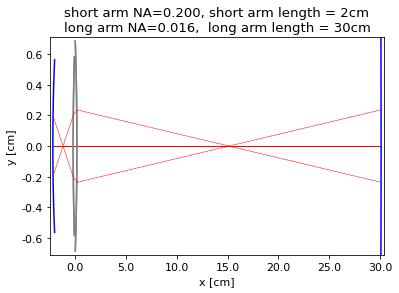

In [ ]:
# %%
# Load data/params_dict.pkl:
font = {'size': 11}
rc('font', **font)
with open('data/params_dict.pkl', 'rb') as f:
    params_dict = pkl.load(f)

axis_span = 0.005
camera_center = -1
lambda_laser = 1064e-9
names = ['Right Mirror', 'lens', 'Left Mirror']

params = params_dict['Sapphire, NA=0.2-0.0365, L1=0.3 - High NA axis']
x_2_values = np.concatenate([np.linspace(-6e-5, 0, 20)])  # np.array([0]),
params_temp = params.copy()
params_temp[1, 0] = x_2_values[-1]  # Change the position of the lens

cavity = Cavity.from_params(params=params_temp, standing_wave=True,
                            lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)
fig, ax = plt.subplots(figsize=(6, 4))
cavity.plot(ax=ax, plane='xz')  #
def mm_format(value, tick_number):
    return f"{value * 1e3:.0f}"


def cm_format(value, tick_number):
    return f"{value * 1e2:.1f}"
ax.yaxis.set_major_formatter(plt.FuncFormatter(cm_format))
ax.xaxis.set_major_formatter(plt.FuncFormatter(cm_format))
ax.set_ylabel("y [cm]")
ax.set_xlabel("x [cm]")

# ax.set_ymargin(0.3)
# ax.set_xlim(x_3 - 0.01, x_1 + 0.01)
# ax.set_ylim(-0.002, 0.002)
ax.set_title(
    f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.3f}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center)*100:.0f}cm\n"
    f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.3f},  long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center)*100:.0f}cm")
plt.savefig('figures/systems/mirror-lens-mirror_high_NA_ratio.svg', dpi=300, bbox_inches='tight')
plt.show()
# %%
NAs_2, tolerance_matrix_2 = generate_tolerance_of_NA(params, parameter_index_for_NA_control=(1, 0),
                                                     arm_index_for_NA=2, parameter_values=x_2_values,
                                                     t_is_trivial=True, p_is_trivial=True,
                                                     return_cavities=False, lambda_laser=lambda_laser)
tolerance_matrix_2 = np.abs(tolerance_matrix_2)
# %%
x_1 = 2.0000000000e-02
y_1 = 0.0000000000e+00
t_1 = 0.0000000000e+00
p_1 = 0.0000000000e+00
r_1 = 1.00000071e-02
x_3 = 0
y_3 = 0.0000000000e+00
t_3 = 0.0000000000e+00
p_3 = 0.0000000000e+00
lambda_laser = 1064e-09
r_3 = r_1
p_3 += np.pi
names = ['Right Mirror', 'Left Mirror']
# INDICES_DICT = {'x': 0, 'y': 1, 't': 2, 'p': 3, 'r': 4, 'n_1': 5, 'w': 6, 'n_2': 7, 'z': 8, 'curvature_sign': 9,
#                 'alpha_thermal_expansion': 10, 'beta_power_absorption': 11, 'kappa_thermal_conductivity': 12,
#                 'dn_dT': 13,
#                 'nu_poisson_ratio': 14, 'alpha_volume_absorption': 15, 'surface_type': 16}
params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, *PHYSICAL_SIZES_DICT['thermal_properties_ULE'].to_array, 0],
                   # [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                   [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, *PHYSICAL_SIZES_DICT['thermal_properties_ULE'].to_array, 0]])
ratios = 1 - np.concatenate((np.array([0]), np.logspace(-7, -3.5, 10, endpoint=True)))
x_1_values = x_1 * ratios
params_temp = params.copy()
params_temp[0, 0] = x_1_values[0]

cavity = Cavity.from_params(params=params_temp, standing_wave=True,
                            lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)
font = {'size': 11}
rc('font', **font)
fig, ax = plt.subplots(figsize=(6, 4))
cavity.plot(axis_span=1, ax=ax)
ax.set_xlim(-0.005, 0.3205)
length = x_1 - x_3 + 0.002
ax.set_ylim(-0.006, 0.006)

def cm_format_shifted(value, tick_number):
    return f"{value * 1e2 - 2:.1f}"
ax.yaxis.set_major_formatter(plt.FuncFormatter(cm_format))
ax.xaxis.set_major_formatter(plt.FuncFormatter(cm_format_shifted))
ax.set_ylabel("y [cm]")
ax.set_xlabel("x [cm]")
ax.set_title(
    f"Fabry Perot, NA={cavity.arms[0].mode_parameters.NA[0]:.3f}, length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center)*100:.0f}cm")

plt.savefig('figures/systems/Fabry-Perot_scaled_x.svg', dpi=300, bbox_inches='tight')
plt.show()
# %%
NAs_1, tolerance_matrix_1 = generate_tolerance_of_NA(params, parameter_index_for_NA_control=(0, 0),
                                                     arm_index_for_NA=0, parameter_values=x_1_values,
                                                     t_is_trivial=True, p_is_trivial=True,
                                                     return_cavities=False)
tolerance_matrix_1 = np.abs(tolerance_matrix_1)
# %%
font = {'size': 20}
rc('font', **font)
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Tilt Tolerance")
ax.plot(NAs_1, tolerance_matrix_1[0, 2, :], label='Fabry-Perot', linestyle=':', color='g')
ax.plot(NAs_2, tolerance_matrix_2[0, 2, :], label='2-arms, right mirror', linestyle='-', color='g')
ax.plot(NAs_2, tolerance_matrix_2[1, 2, :], label='2-arms, lens', linestyle='--', color='b')
ax.plot(NAs_2, tolerance_matrix_2[2, 2, :], label='2-arms, left mirror', linestyle='-', color='orange')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Numerical Aperture')
ax.set_ylabel('Tolerance [rad]')
ax.grid()
# ax.legend()
plt.tight_layout()
plt.savefig('figures/NA tolerance/comparison_tilt.svg', dpi=300, bbox_inches='tight')
plt.show()
# %%
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Axial Displacement Tolerance")
ax.plot(NAs_1, tolerance_matrix_1[0, 0, :], label='Fabry-Perot', linestyle=':', color='g')
ax.plot(NAs_2, tolerance_matrix_2[0, 0, :], label='2-arms, right mirror', linestyle='-', color='g')
ax.plot(NAs_2, tolerance_matrix_2[1, 0, :], label='2-arms, lens', linestyle='--', color='b', linewidth=2.2)
ax.plot(NAs_2, tolerance_matrix_2[2, 0, :], label='2-arms, left mirror', linestyle='-', color='orange')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Numerical Aperture')
ax.set_ylabel('Tolerance [m]')
ax.grid()
# ax.legend()
plt.tight_layout()
plt.savefig('figures/NA tolerance/comparison_lateral.svg', dpi=300, bbox_inches='tight')
plt.show()
# %%
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Transversal Displacement Tolerance")
ax.plot(NAs_1, tolerance_matrix_1[0, 1, :], label='Fabry-Perot', linestyle=':', color='g')
ax.plot(NAs_2, tolerance_matrix_2[0, 1, :], label='2-arms, right mirror', linestyle='-', color='g')
ax.plot(NAs_2, tolerance_matrix_2[1, 1, :], label='2-arms, lens', linestyle='--', color='b', linewidth=2.2)
ax.plot(NAs_2, tolerance_matrix_2[2, 1, :], label='2-arms, left mirror', linestyle='-', color='orange')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Numerical Aperture')
ax.set_ylabel('Tolerance [m]')
ax.grid()
# ax.legend()
plt.tight_layout()
plt.savefig('figures/NA tolerance/comparison_transversal.svg', dpi=300, bbox_inches='tight')
plt.show()
# %%
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Radius Change Tolerance")
ax.plot(NAs_1, tolerance_matrix_1[0, 4, :], label='Fabry-Perot', linestyle=':', color='g')
ax.plot(NAs_2, tolerance_matrix_2[0, 4, :], label='2-arms, right mirror', linestyle='-', color='g')
ax.plot(NAs_2, tolerance_matrix_2[1, 4, :], label='2-arms, lens', linestyle='--', color='b', linewidth=2.2)
ax.plot(NAs_2, tolerance_matrix_2[2, 4, :], label='2-arms, left mirror', linestyle='-', color='orange')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Numerical Aperture')
ax.set_ylabel('Tolerance [m]')
ax.grid()
# ax.legend()
plt.tight_layout()
plt.savefig('figures/NA tolerance/comparison_radius.svg', dpi=300, bbox_inches='tight')
plt.show()


## Fully create and characterize a single cavity, with both types of plots:

In [ ]:
print_parameters = True
NA_1 = 2.0000000000e-01
R = -2.2518917420e+00
w = -3.0000000000e+00
n = 1.5000000000e+00
right_arm_length = -1.4810524510e+00
auto_set_right_arm_length = False
mirror_on_waist = True

auto_set_axes = 1.0000000000e+00
axis_span = None

R = 10 ** R
w = 10 ** w
right_arm_length = 10 ** right_arm_length
lambda_laser = 1.064e-6
x_1_tag = -w / 2 - 0.01
# NA_1 = 0.10004148
z_R_1 = lambda_laser / (np.pi * NA_1 ** 2)
mode_1_center = np.array([-0.00595413, 0, 0])
mode_1_k_vector = np.array([1, 0, 0])
mode_2_x = 0.1
mode_1 = ModeParameters(center=np.stack([mode_1_center, mode_1_center], axis=0), k_vector=mode_1_k_vector,
                        z_R=np.array([z_R_1, z_R_1]),
                        principle_axes=np.array([[0, 0, 1], [0, 1, 0]]), lambda_laser=lambda_laser)
mirror_1 = match_a_mirror_to_mode(mode_1, x_1_tag - mode_1.center[0, 0], PHYSICAL_SIZES_DICT['thermal_properties_ULE'])
# INDICES_DICT = {'x': 0, 'y': 1, 't': 2, 'p': 3, 'r': 4, 'n_1': 5, 'w': 6, 'n_2': 7, 'z': 8, 'curvature_sign': 9,
#                 'alpha_thermal_expansion': 10, 'beta_power_absorption': 11, 'kappa_thermal_conductivity': 12,
#                 'dn_dT': 13,
#                 'nu_poisson_ratio': 14, 'alpha_volume_absorption': 15, 'surface_type': 16}
lens_params = np.array([0, 0, 0, 0, R, n, w, 1, 0, -1, *PHYSICAL_SIZES_DICT['thermal_properties_sapphire'].to_array, 1])
surface_1, surface_2 = generate_lens_from_params(lens_params, names=['lens_left', 'lens_right'])
local_mode_1 = mode_1.local_mode_parameters(np.linalg.norm(surface_1.center - mode_1.center[0]))
local_mode_2 = local_mode_2_of_lens_parameters(np.array([R, w, n]), local_mode_1)
mode_2 = local_mode_2.to_mode_parameters(location_of_local_mode_parameter=surface_2.center,
                                         k_vector=mode_1_k_vector, lambda_laser=lambda_laser)

if auto_set_right_arm_length:
    z_minus_z_0 = - local_mode_2.z_minus_z_0[0]
elif mirror_on_waist:
    z_minus_z_0 = 0
else:
    z_minus_z_0 = local_mode_2.z_minus_z_0[0] + right_arm_length

mirror_3 = match_a_mirror_to_mode(mode_2, z_minus_z_0, PHYSICAL_SIZES_DICT['thermal_properties_ULE'])

mirror_1_params = mirror_1.to_params
mirror_3_params = mirror_3.to_params
lens_params = lens_params.astype(np.complex128)
lens_params[3] = 1j
params = np.stack([mirror_3_params, lens_params, mirror_1_params], axis=0)

camera_center = -1
lambda_laser = 1064e-9
names = ['Right Mirror', 'lens', 'Left Mirror']

x_2_values = np.linspace(-5.31e-6, 0, 8)
# x_2_values = np.concatenate((-np.logspace(-4.5, -7.5, 5), np.array([0])))
# x_2_values = np.array([0])
params_temp = params.copy()
params_temp[1, 0] = x_2_values[-1]

cavity = Cavity.from_params(params=params_temp, standing_wave=True,
                            lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)

fig, ax = plt.subplots(figsize=(13, 5))
cavity.plot(axis_span=axis_span, camera_center=camera_center, ax=ax, plane='xz')  #
# ax.set_xlim(x_3 - 0.01, x_1 + 0.01)
# ax.set_ylim(-0.002, 0.002)
if auto_set_right_arm_length:
    symmetry_title = '(Symmetric)'
else:
    symmetry_title = '(Asymmetric)'
title = f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.2e} [m]\n" + \
        f"                      long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e},   long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} [m] {symmetry_title}"

ax.set_title(title)
plt.savefig(f'figures/systems/mirror-lens-mirror_high_NA_ratio_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e}.svg', dpi=300, bbox_inches='tight')
plt.show()
# %%
NAs, tolerance_matrix = generate_tolerance_of_NA(params, parameter_index_for_NA_control=(1, 0),
                                                 arm_index_for_NA=2, parameter_values=x_2_values,
                                                 t_is_trivial=True, p_is_trivial=True,
                                                 return_cavities=False, lambda_laser=lambda_laser)

# %%
plot_tolerance_of_NA_same_plot(params=params, names=names, NAs=NAs, tolerance_matrix=np.abs(tolerance_matrix),
                               t_and_p_are_trivial=True)
plt.suptitle(title)
# plt.savefig(
#     f'figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_smart_choice_overlaps_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e}.svg',
#     dpi=300, bbox_inches='tight')
plt.show()

# %%
overlaps_series = cavity.generate_overlap_series(shifts=2 * np.abs(tolerance_matrix[:, :, -1]),
                                                 shift_size=30,
                                                 print_progress=False)

# %%
cavity.generate_overlaps_graphs(overlaps_series=overlaps_series, tolerance_matrix=tolerance_matrix[:, :, -1],
                                arm_index_for_NA=2)
plt.suptitle(title)
# plt.savefig(
#     f'figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_smart_choice_tolerance_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e}.svg',
#     dpi=300, bbox_inches='tight')
plt.show()

# %%
winsound.Beep(880, 200)

## Draw cavity in both planes, left side and whole cavity, heated and unheated:

In [ ]:
    parameter_index = 1
    element = 0
    shifts_max = -7
    shifts_n = 1.0000000000e+01
    shift_percentile_for_plotting = 5.0000000000e-01
    x_2 = 0
    x_2_small_perturbation = 0
    camera_center=-1

    # Load data/params_dict.pkl:
    with open('data/params_dict.pkl', 'rb') as f:
        params_dict = pkl.load(f)


    lambda_laser = 1064e-9
    names = ['Right Mirror', 'lens', 'Left Mirror']
    dim = 2
    axis_span = None

    def mm_format(value, tick_number):
        return f"{value * 1e3:.2f}"


    def cm_format(value, tick_number):
        return f"{value * 1e2:.2f}"

    font = {'size'   : 19}
    rc('font', **font)
    for key in params_dict.keys():
        fig, ax = plt.subplots(4, 2, figsize=(24,20))
        for aspect_ratio in [False, True]:  #
            for left_side_only in [False, True]:  #

                cavity = Cavity.from_params(params=params_dict[key], set_initial_surface=False, standing_wave=True,
                                            lambda_laser=lambda_laser, power=50000,
                                            p_is_trivial=True, t_is_trivial=True, names=names)
                if aspect_ratio:
                    aspect_ratio_title = "even aspect ratio"
                    i = 0
                else:
                    aspect_ratio_title = "uneven aspect ratio"
                    i = 2
                if left_side_only:
                    left_side_title = "short arm only"
                    j = 0
                else:
                    left_side_title = "whole cavity"
                    j = 1
                x_3 = cavity.to_params(convert_to_pies=True)[2, 0]
                x_2 = cavity.to_params(convert_to_pies=True)[1, 0]
                diff = np.abs(x_3 - x_2)
                unheated_cavity = cavity.thermal_transformation()
                if aspect_ratio and not left_side_only:
                    cavity.print_table()
                plt.subplots_adjust(hspace=0.4, right=0.98, left=0.125)
                fig.suptitle(key)
                cavity.plot(ax=ax[i+1, j])
                ax[i+1, j].set_title(f"High power, {left_side_title}, {aspect_ratio_title}")
                ax[i+1, j].yaxis.set_major_formatter(plt.FuncFormatter(mm_format))
                ax[i+1, j].xaxis.set_major_formatter(plt.FuncFormatter(cm_format))
                ax[i+1, j].set_ylabel("y [mm]")
                ax[i+1, j].set_xlabel("x [cm]")
                ax[i+1, j].set_ymargin(0.3)

                if left_side_only:
                    ax[i+1, j].set_xlim(x_3 - 0.15 * diff, x_2 + 0.15 * diff)
                if aspect_ratio:
                    subplot_size = ax[i+1, j].get_window_extent().size
                    subplot_size_ratio = subplot_size[1] / subplot_size[0]
                    xlim = ax[i+1, j].get_xlim()
                    x_length = xlim[1] - xlim[0]
                    ax[i+1, j].set_ylim(x_length * subplot_size_ratio / 2, -x_length * subplot_size_ratio / 2)



                unheated_cavity.plot(ax=ax[i, j])
                ax[i, j].set_title(f"Low power, {left_side_title}, {aspect_ratio_title}")


                ax[i, j].yaxis.set_major_formatter(plt.FuncFormatter(mm_format))
                ax[i, j].xaxis.set_major_formatter(plt.FuncFormatter(cm_format))
                ax[i, j].set_ylabel("y [mm]")
                ax[i, j].set_xlabel("x [cm]")
                ax[i, j].set_xlim(ax[i+1, j].get_xlim())
                ax[i, j].set_ylim(ax[i+1, j].get_ylim())
                plt.savefig(f"figures/systems/{key}.svg")

        plt.show()

## compare the difference between cold and hot cavity for different hot NA - the difference changes sign

In [4]:
x_1 = 0.0000000000e+00
x_1_small_perturbation = 0.0000000000e+00
y_1 = 0.0000000000e+00
t_1 = 1j * 0.0000000000e+00
p_1 = 1j * 0.0000000000e+00
r_1 = 1.2203660000e-02
x_2 = 0.0000000000e+00
y_2 = 0.0000000000e+00
t_2 = 1j * 0.0000000000e+00
p_2 = 1j * 0.0000000000e+00
r_2 = 0.0000000000e+00
w_2 = 2.1684043450e-19
n_in = 0.0000000000e+00
x_3 = 2.2204460493e-16
x_3_small_perturbation = 0.0000000000e+00
y_3 = 0.0000000000e+00
t_3 = 1j * 0.0000000000e+00
p_3 = 1j * 0.0000000000e+00
r_3 = 0.0000000000e+00
lambda_laser = 1.0640000000e-06
elev = 38.00
azim = 168.00
camera_center = -1
dim = 2
axis_span = -0.4500000000000002
savefig = False
automatic_axis_span = True
power_laser = 5.0000000000e+04
print_parameters = True

# font = {'size'   : 22}
# rc('font', **font)

CONSTANT_PARAMS = np.array([[2.7424349948e-01 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 0.j, 1.3688702599e-01 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             1.0000000000e+00 + 0.j, 4.8000000000e-07 + 0.j, 1.0000000000e-06 + 0.j,
                             1.3800000000e+00 + 0.j, 1.2000000000e-05 + 0.j, 1.5000000000e-01 + 0.j,
                             0.0000000000e+00 + 0.j],
                            [1.7347234760e-18 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 1.j, 1.4454397707e-02 + 0.j, 1.7600000000e+00 + 0.j,
                             1.0000000000e-03 + 0.j, 1.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 0.j, 5.5000000000e-06 + 0.j, 1.0000000000e-06 + 0.j,
                             4.6060000000e+01 + 0.j, 1.1700000000e-05 + 0.j, 3.0000000000e-01 + 0.j,
                             1.0000000000e+00 + 0.j],
                            [-2.0500000000e-02 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             -0.0000000000e+00 - 1.j, 1.0000007169e-02 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             1.0000000000e+00 + 0.j, 4.8000000000e-07 + 0.j, 1.0000000000e-06 + 0.j,
                             1.3800000000e+00 + 0.j, 1.2000000000e-05 + 0.j, 1.5000000000e-01 + 0.j,
                             0.0000000000e+00 + 0.j]])

if automatic_axis_span:
    axis_span = None
else:
    axis_span = 10 ** axis_span

x_1 += x_1_small_perturbation
x_3 += x_3_small_perturbation
# x_2 += x_2_small_perturbation
N = 100
high_power_NA = np.zeros(N)
low_power_NA = np.zeros(N)
r_1s = np.linspace(0, 5e-2, N)
for i, r_1 in enumerate(r_1s):
    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [x_2, y_2, t_2, p_2, r_2, n_in, w_2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).astype('complex128')

    params += CONSTANT_PARAMS
    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                                lambda_laser=lambda_laser, power=power_laser, p_is_trivial=True, t_is_trivial=True)
    unheated_cavity = cavity.thermal_transformation()
    low_power_NA[i] = unheated_cavity.arms[2].mode_parameters.NA[0]
    high_power_NA[i] = cavity.arms[2].mode_parameters.NA[0]

N_0 = 10
plt.plot(high_power_NA[N_0:], low_power_NA[N_0:], label="low power mode", linewidth=0.5)
plt.plot(high_power_NA[N_0:], high_power_NA[N_0:], '--', label="x=y", linewidth=0.5)
plt.xlabel("High power NA")
plt.ylabel("Low power NA")
# plt.xscale('log')
# plt.ylim(0.99*high_power_NA[-1], high_power_NA[0])
# plt.xlim(0.99 * high_power_NA[-1], high_power_NA[0])
# plt.yscale('log')
plt.title("Low power NA as a function of the high power NA")
plt.tight_layout()
plt.legend()

plt.show()


####################################################
x_1 = 0.0000000000e+00
x_1_small_perturbation = 0.0000000000e+00
y_1 = 0.0000000000e+00
t_1 = 1j * 0.0000000000e+00
p_1 = 1j * 0.0000000000e+00
r_1 = 1.2203660000e-02
x_2 = 0.0000000000e+00
y_2 = 0.0000000000e+00
t_2 = 1j * 0.0000000000e+00
p_2 = 1j * 0.0000000000e+00
r_2 = 0.0000000000e+00
w_2 = 2.1684043450e-19
n_in = 0.0000000000e+00
x_3 = 2.2204460493e-16
x_3_small_perturbation = 0.0000000000e+00
y_3 = 0.0000000000e+00
t_3 = 1j * 0.0000000000e+00
p_3 = 1j * 0.0000000000e+00
r_3 = 0.0000000000e+00
lambda_laser = 1.0640000000e-06
elev = 38.00
azim = 168.00
camera_center = -1
dim = 2
axis_span = -0.4500000000000002
savefig = False
automatic_axis_span = True
power_laser = 5.0000000000e+04
print_parameters = True

# font = {'size'   : 22}
# rc('font', **font)

CONSTANT_PARAMS = np.array([[2.7424349948e-01 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 0.j, 1.3688702599e-01 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             1.0000000000e+00 + 0.j, 4.8000000000e-07 + 0.j, 1.0000000000e-06 + 0.j,
                             1.3800000000e+00 + 0.j, 1.2000000000e-05 + 0.j, 1.5000000000e-01 + 0.j,
                             0.0000000000e+00 + 0.j],
                            [1.7347234760e-18 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 1.j, 1.4454397707e-02 + 0.j, 1.7600000000e+00 + 0.j,
                             1.0000000000e-03 + 0.j, 1.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 0.j, 5.5000000000e-06 + 0.j, 1.0000000000e-06 + 0.j,
                             4.6060000000e+01 + 0.j, 1.1700000000e-05 + 0.j, 3.0000000000e-01 + 0.j,
                             1.0000000000e+00 + 0.j],
                            [-2.0500000000e-02 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             -0.0000000000e+00 - 1.j, 1.0000007169e-02 + 0.j, 0.0000000000e+00 + 0.j,
                             0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                             1.0000000000e+00 + 0.j, 4.8000000000e-07 + 0.j, 1.0000000000e-06 + 0.j,
                             1.3800000000e+00 + 0.j, 1.2000000000e-05 + 0.j, 1.5000000000e-01 + 0.j,
                             0.0000000000e+00 + 0.j]])

if automatic_axis_span:
    axis_span = None
else:
    axis_span = 10 ** axis_span

x_1 += x_1_small_perturbation
x_3 += x_3_small_perturbation
# x_2 += x_2_small_perturbation
N = 100
high_power_NA = np.zeros(N)
low_power_NA = np.zeros(N)
r_1s = np.linspace(0, 5e-2, N)
for i, r_1 in enumerate(r_1s):
    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [x_2, y_2, t_2, p_2, r_2, n_in, w_2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).astype('complex128')

    params += CONSTANT_PARAMS
    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                                lambda_laser=lambda_laser, power=power_laser, p_is_trivial=True, t_is_trivial=True)
    unheated_cavity = cavity.thermal_transformation()
    low_power_NA[i] = unheated_cavity.arms[2].mode_parameters.NA[0]
    high_power_NA[i] = cavity.arms[2].mode_parameters.NA[0]

N_0 = 10
plt.plot(high_power_NA[N_0:], low_power_NA[N_0:], label="low power mode", linewidth=0.5)
plt.plot(high_power_NA[N_0:], high_power_NA[N_0:], '--', label="x=y", linewidth=0.5)
plt.xlabel("High power NA")
plt.ylabel("Low power NA")
# plt.xscale('log')
# plt.ylim(0.99*high_power_NA[-1], high_power_NA[0])
# plt.xlim(0.99 * high_power_NA[-1], high_power_NA[0])
# plt.yscale('log')
plt.title("Low power NA as a function of the high power NA")
plt.tight_layout()
plt.legend()

plt.show()

ValueError: not enough values to unpack (expected 17, got 16)

## Decompose thermal transformations to different contributions:

Sapphire, NA=0.1-0.039, L1=0.3 - Low NA axis


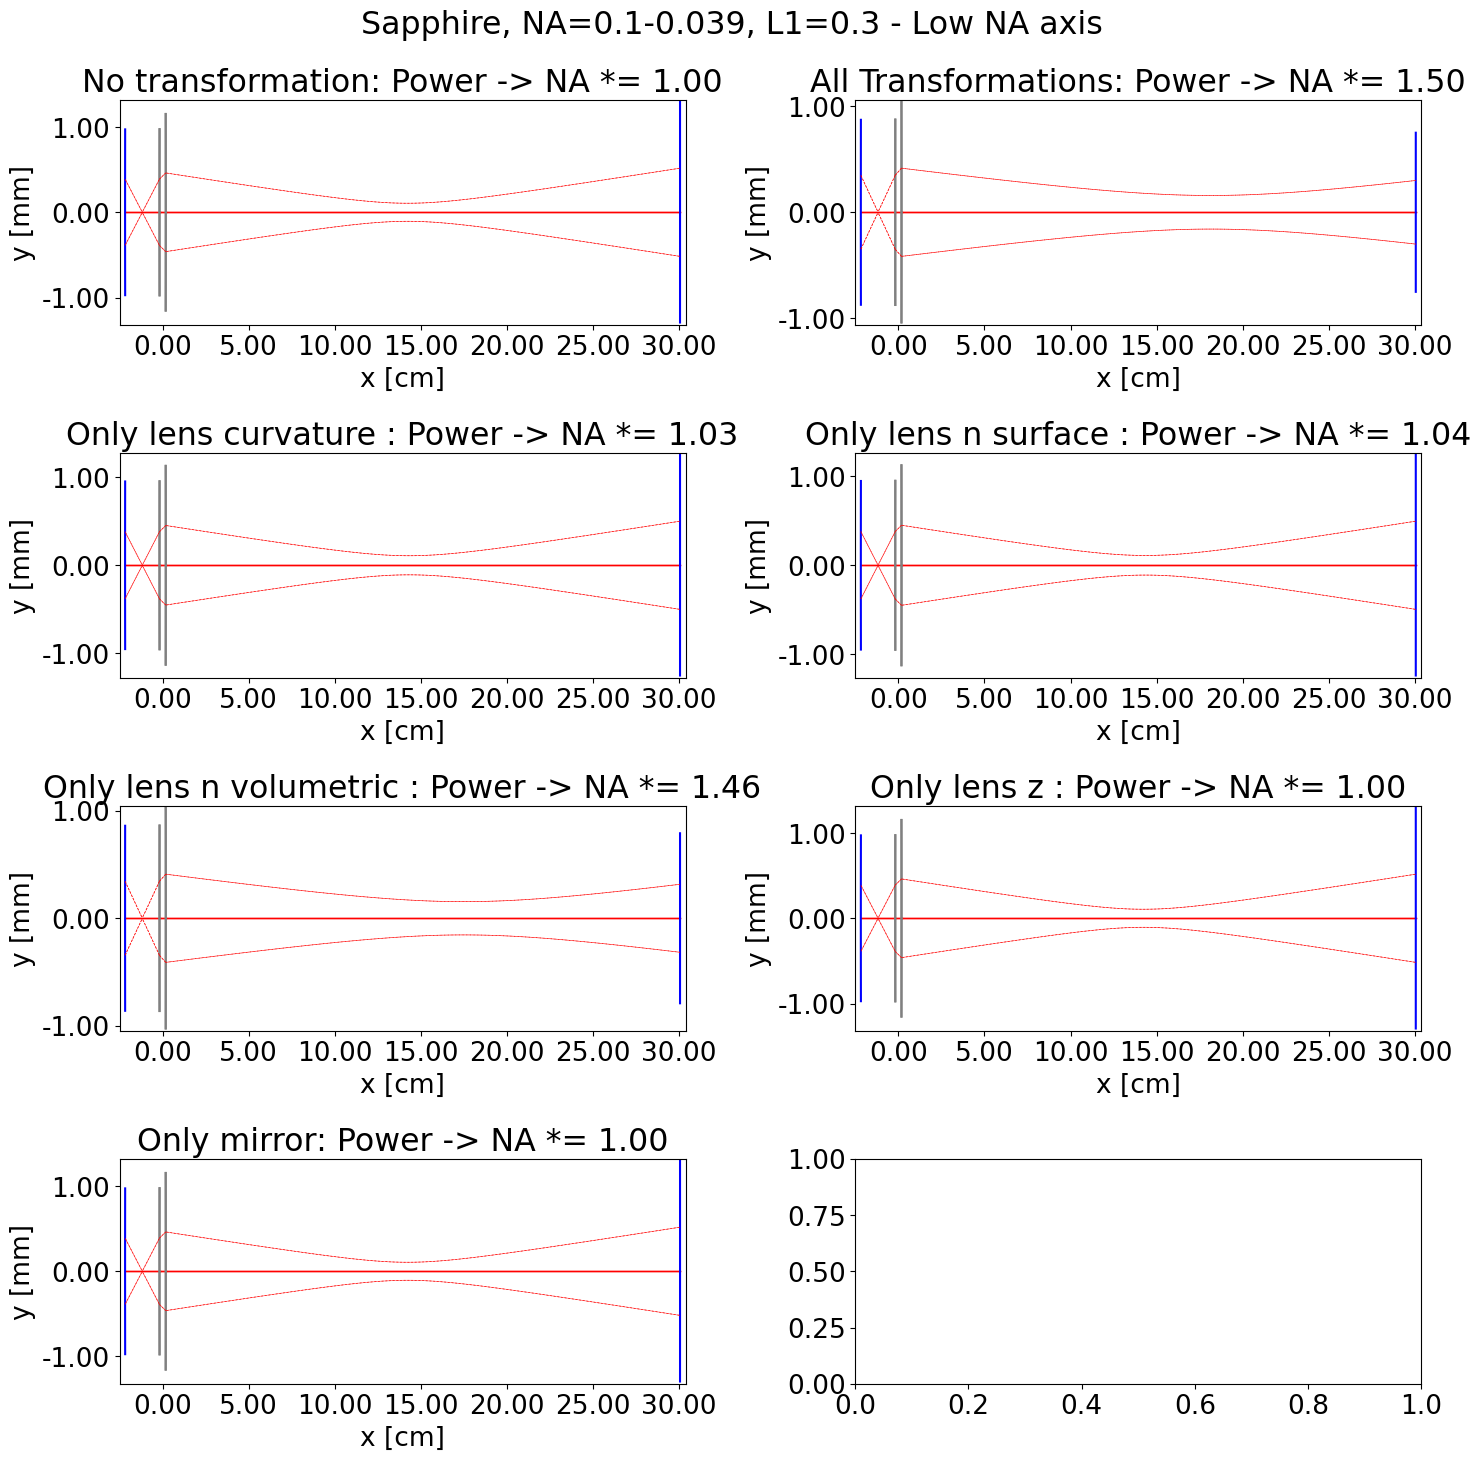

In [13]:
    lambda_laser=1064e-9
    power = 5e4
    overlap_threshold = 0.9
    initial_step = 1e-6

    def mm_format(value, tick_number):
        return f"{value * 1e3:.2f}"


    def cm_format(value, tick_number):
        return f"{value * 1e2:.2f}"

    with open('data/params_dict.pkl', 'rb') as f:
        params_dict = pkl.load(f)  # Sapphire, NA=0.1/0.039, Long arm length=0.3
    for key in ['Sapphire, NA=0.1-0.039, L1=0.3 - Low NA axis']:  # params_dict.keys():
        print(key)
        cavity = Cavity.from_params(params=params_dict[key], standing_wave=True, lambda_laser=lambda_laser,
                                    names=['Long Arm Mirror', 'Lens', 'Short Arm Mirror'], t_is_trivial=True,
                                    p_is_trivial=True, power=power)
        results_dict, cavities = cavity.analyze_thermal_transformation(0)

        fig, axes = plt.subplots(4, 2, figsize=(15, 15))
        for i, key_trans in enumerate(results_dict.keys()):
            ax = axes.flatten()[i]
            cavities[i].plot(ax=ax)
            ax.set_title(f"{key_trans}: Power -> NA *= {results_dict[key_trans]:.2f}")
            ax.yaxis.set_major_formatter(plt.FuncFormatter(mm_format))
            ax.xaxis.set_major_formatter(plt.FuncFormatter(cm_format))
            ax.set_ylabel("y [mm]")
            ax.set_xlabel("x [cm]")
        fig.suptitle(key)
        fig.tight_layout()
        plt.savefig(f"figures/thermal transformations/{key}.svg")
        plt.show()

### Comparing sapphire and fused silica lenses, lengths measured from len's surfaces:

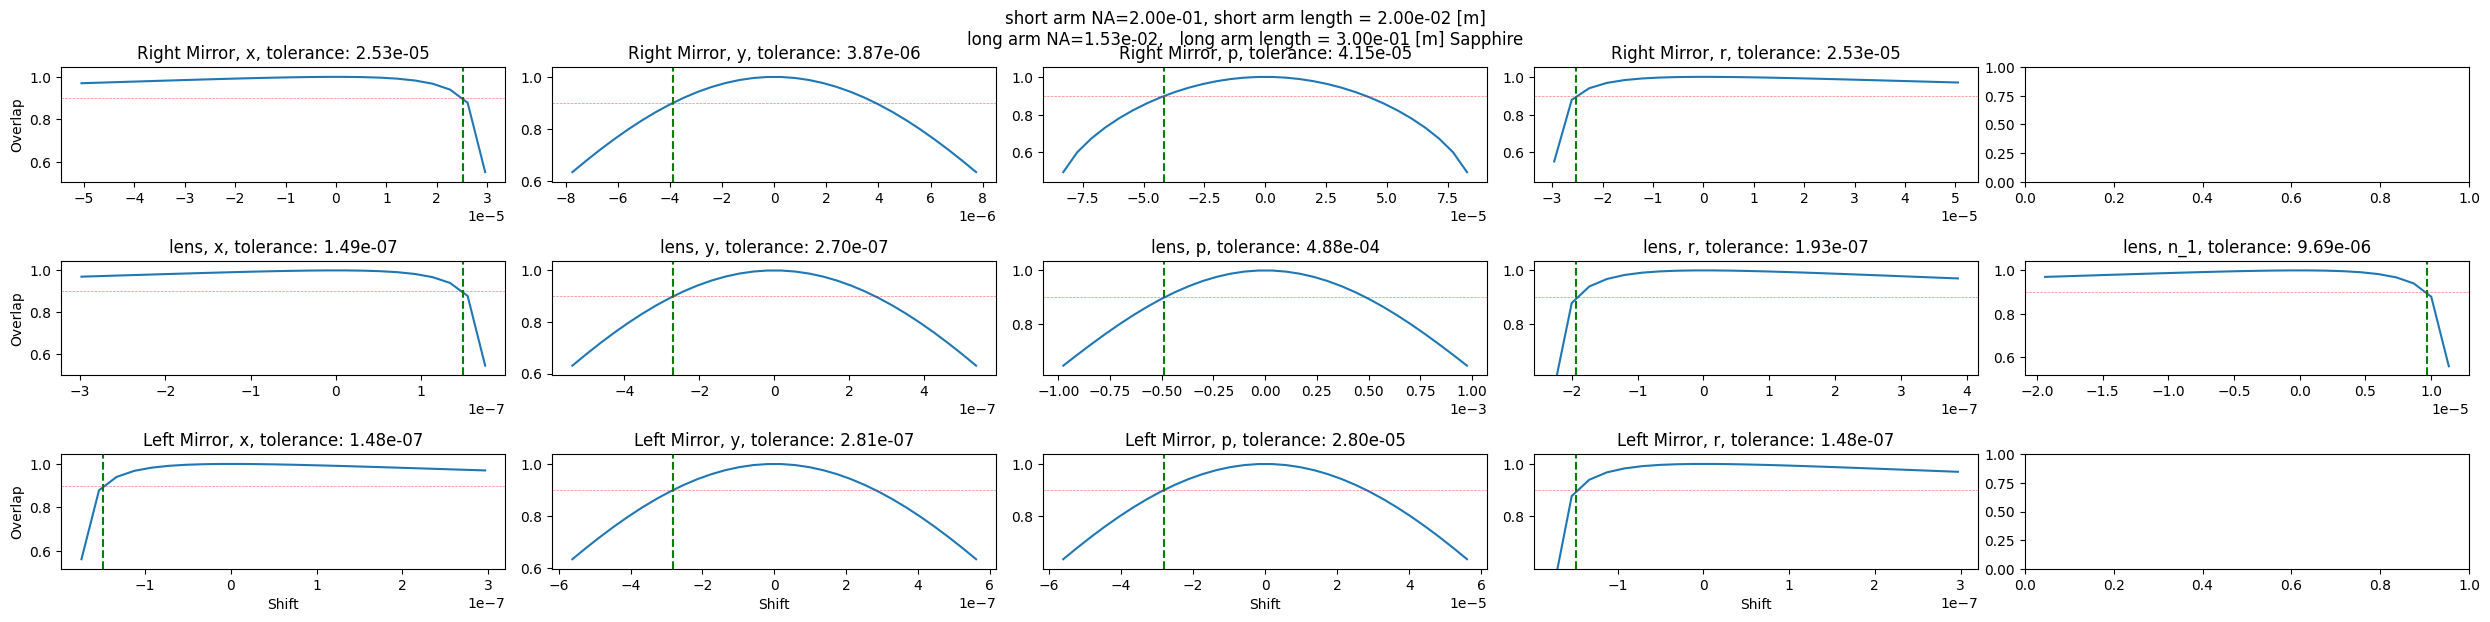

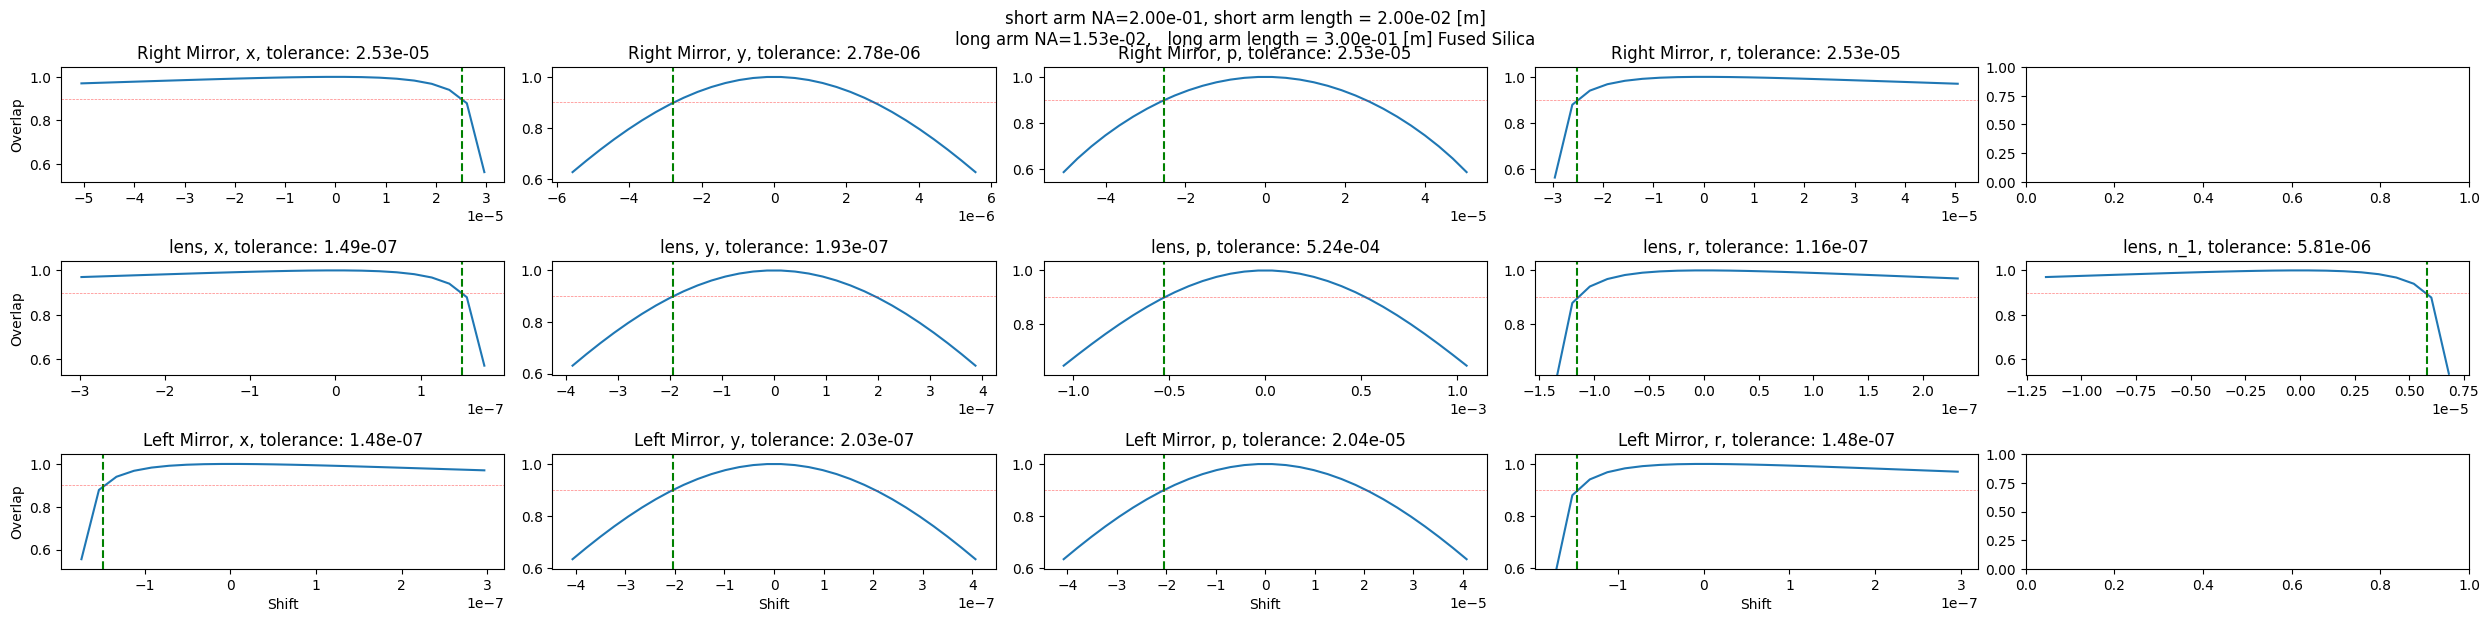

In [8]:
# %%
with open('data/params_dict.pkl', 'rb') as f:
    params_dict = pkl.load(f)

lenses_types = ['Sapphire', 'Fused Silica']
for i, params_name in enumerate(['Sapphire, NA=0.2, L1=0.3, w=3mm - High NA axis',  'Fused Silica, NA=0.2, L1=0.3, w=3mm - High NA axis']):
    w='3mm'
    params = params_dict[params_name]


    mirror_on_waist = True
    auto_set_axes = 1.0000000000e+00
    axis_span = None
    camera_center = -1
    lambda_laser = 1064e-9
    names = ['Right Mirror', 'lens', 'Left Mirror']

    cavity = Cavity.from_params(params=params, standing_wave=True,
                                lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)

    # fig, ax = plt.subplots(figsize=(13, 5))
    # cavity.plot(axis_span=axis_span, camera_center=camera_center, ax=ax, plane='xz')  #
    # ax.set_xlim(x_3 - 0.01, x_1 + 0.01)
    # ax.set_ylim(-0.002, 0.002)
    title = f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.2e} [m]\n" + \
            f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e},   long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} [m] {lenses_types[i]}"

    # ax.set_title(title)
    # plt.savefig(
        # f'figures/systems/mirror-lens-mirror_high_NA_ratio_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} w={w}.svg',
        # dpi=300, bbox_inches='tight')
    # plt.show()
    # %%
    tolerance_matrix = cavity.generate_tolerance_threshold_matrix(print_progress=False)

    # %%
    overlaps_series = cavity.generate_overlap_series(shifts=2 * np.abs(tolerance_matrix[:, :]),
                                                     shift_size=30,
                                                     print_progress=False)

    # %%
    cavity.generate_overlaps_graphs(overlaps_series=overlaps_series, tolerance_matrix=tolerance_matrix[:, :],
                                    arm_index_for_NA=2)
    plt.suptitle(title)
    # plt.savefig(f'figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_smart_choice_tolerance_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} w={w}.svg',
        # dpi=300, bbox_inches='tight')
    plt.show()

### Comparing sapphire and fused silica lenses, lengths measured from len's center:

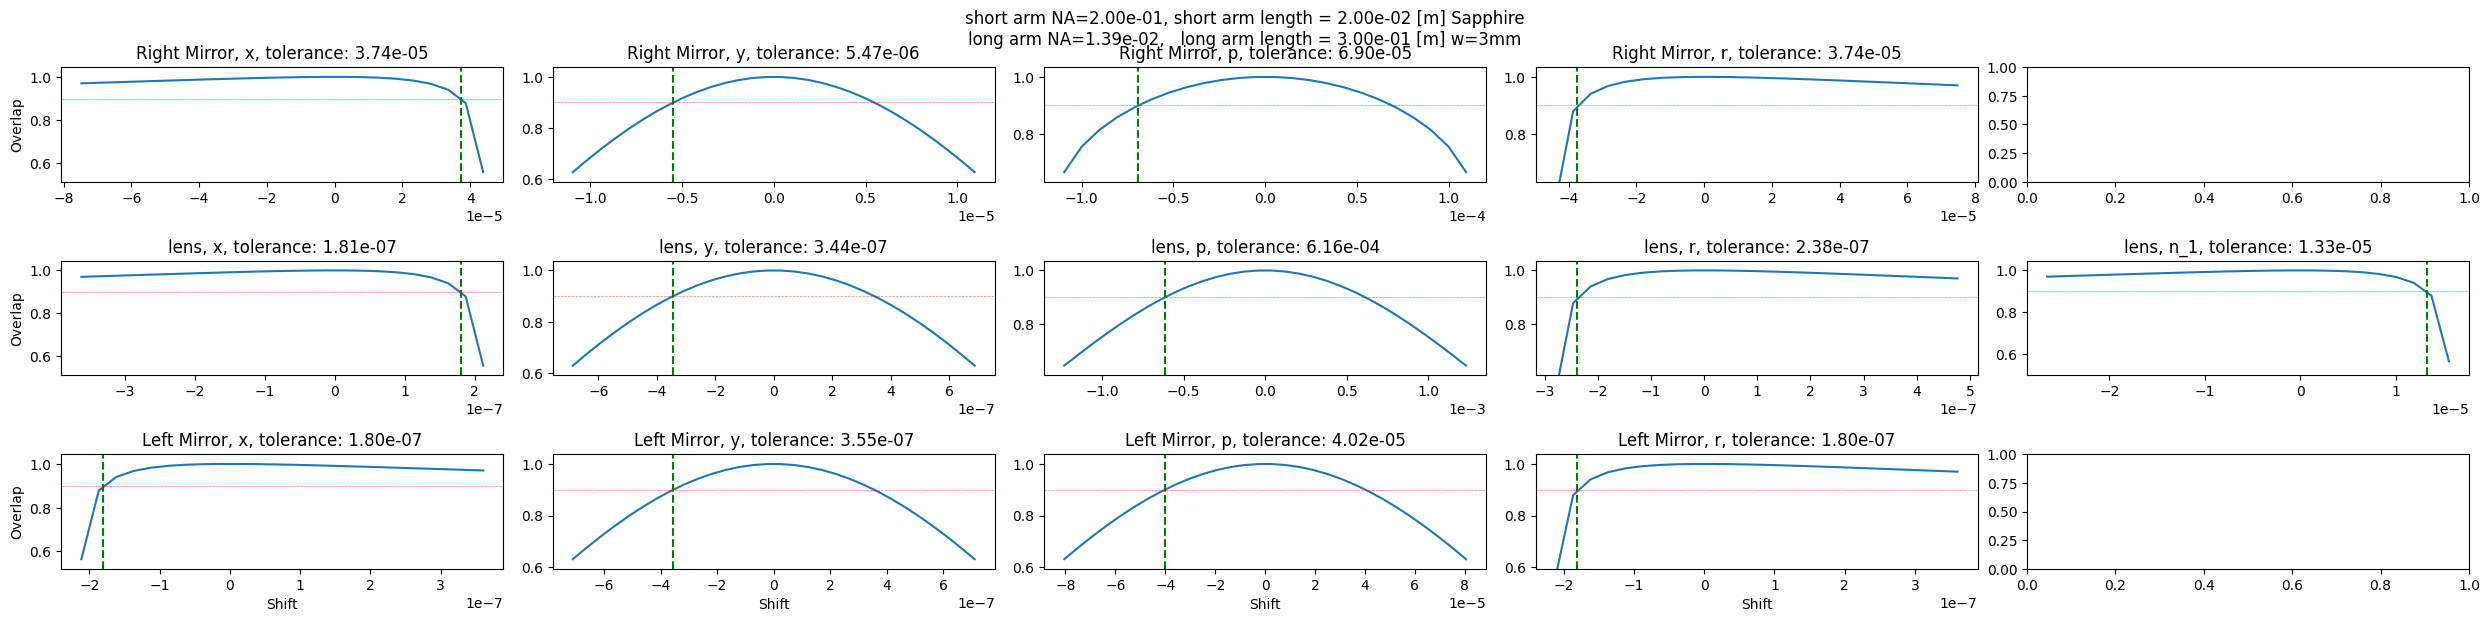

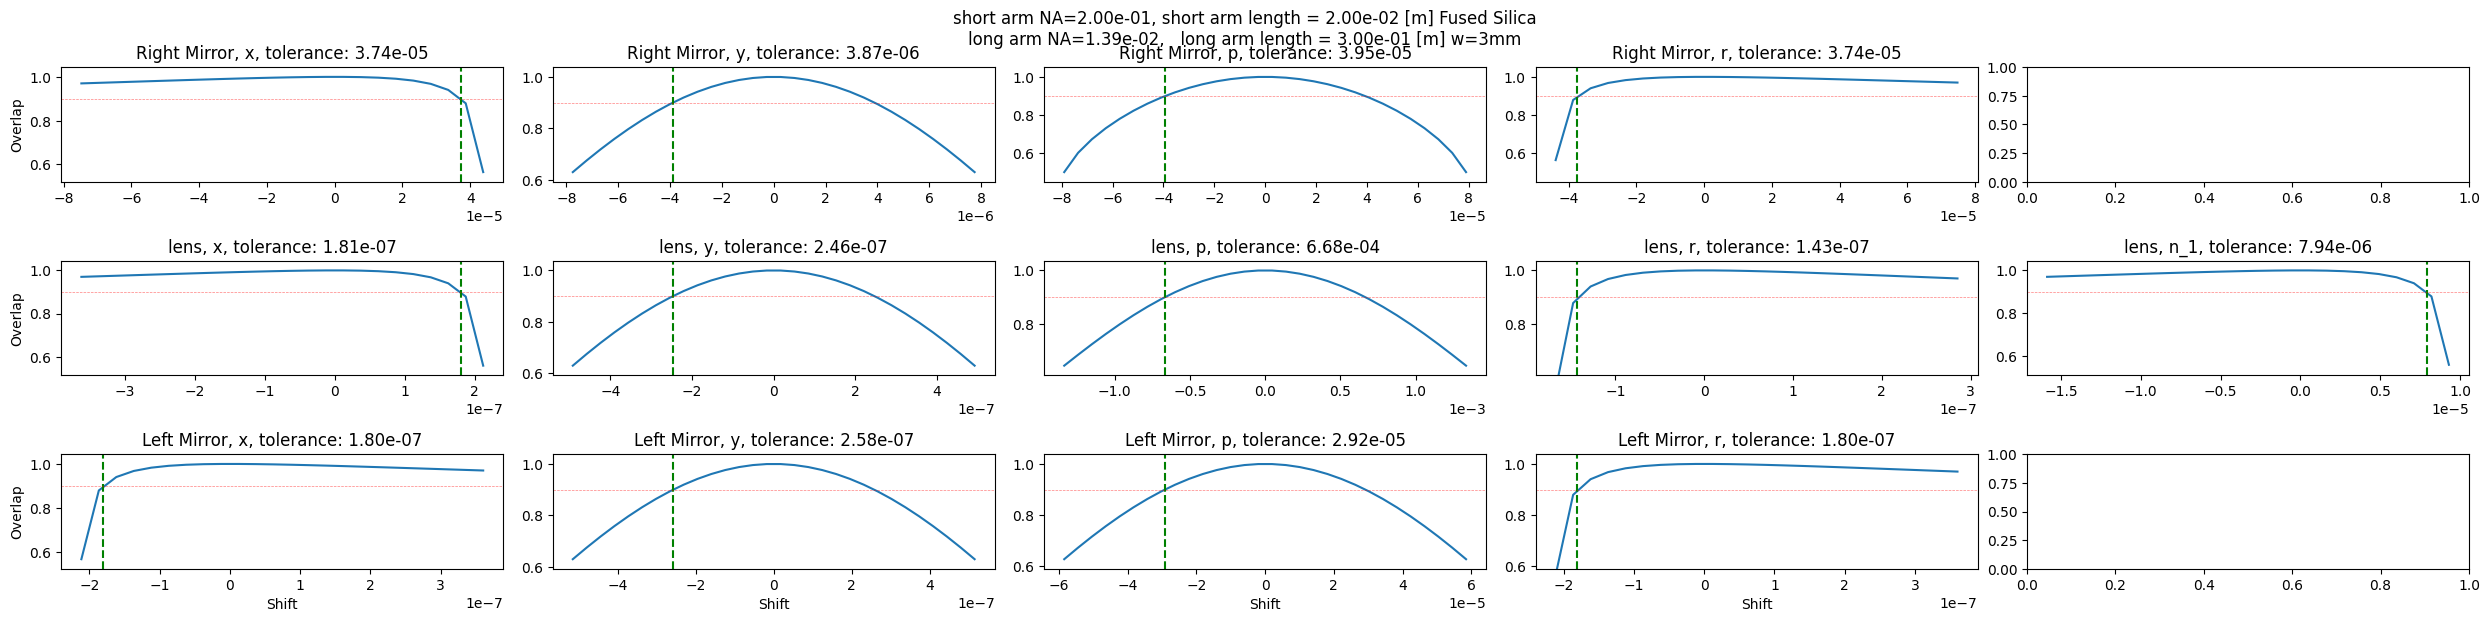

In [9]:
params_list = [np.array([[ 3.0391834335e-01+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  1.4923071669e-01+0.j,  0.0000000000e+00+0.j,
     0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  1.0000000000e+00+0.j,  1.0000000000e-08+0.j,  1.0000000000e-06+0.j,
     1.3100000000e+00+0.j,  0.0000000000e+00+0.j,  1.7000000000e-01+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j],
   [ 4.0000000000e-03+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+1.j,  1.3646319612e-02+0.j,  1.7600000000e+00+0.j,
     2.9964809220e-03+0.j,  1.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  5.5000000000e-06+0.j,  1.0000000000e-06+0.j,
     4.6060000000e+01+0.j,  1.1700000000e-05+0.j,  3.0000000000e-01+0.j,  3.0000000000e-02+0.j,  1.0000000000e+00+0.j],
   [-1.5179523539e-02+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j, -0.0000000000e+00-1.j,  8.8406496482e-03+0.j,  0.0000000000e+00+0.j,
     0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j,  1.0000000000e+00+0.j,  1.0000000000e-08+0.j,  1.0000000000e-06+0.j,
     1.3100000000e+00+0.j,  0.0000000000e+00+0.j,  1.7000000000e-01+0.j,  0.0000000000e+00+0.j,  0.0000000000e+00+0.j]]),
               np.array(
                   [[3.0395758172e-01 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                     1.4925034392e-01 + 0.j, 0.0000000000e+00 + 0.j,
                     0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 1.0000000000e+00 + 0.j,
                     1.0000000000e-08 + 0.j, 1.0000000000e-06 + 0.j,
                     1.3100000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 1.7000000000e-01 + 0.j, 0.0000000000e+00 + 0.j,
                     0.0000000000e+00 + 0.j],
                    [4.0000000000e-03 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 1.j,
                     8.1699108961e-03 + 0.j, 1.4550000000e+00 + 0.j,
                     2.9964809220e-03 + 0.j, 1.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                     4.8000000000e-07 + 0.j, 1.0000000000e-06 + 0.j,
                     1.3800000000e+00 + 0.j, 1.2000000000e-05 + 0.j, 1.5000000000e-01 + 0.j, 1.0000000000e-03 + 0.j,
                     1.0000000000e+00 + 0.j],
                    [-1.5179523539e-02 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j,
                     -0.0000000000e+00 - 1.j,
                     8.8406496482e-03 + 0.j, 0.0000000000e+00 + 0.j,
                     0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 1.0000000000e+00 + 0.j,
                     1.0000000000e-08 + 0.j, 1.0000000000e-06 + 0.j,
                     1.3100000000e+00 + 0.j, 0.0000000000e+00 + 0.j, 1.7000000000e-01 + 0.j, 0.0000000000e+00 + 0.j,
                     0.0000000000e+00 + 0.j]])
               ]
systems_names = ["Sapphire", "Fused Silica"]
for i, params in enumerate(params_list):
    w='3mm'
    # params = params_dict[params_name]


    mirror_on_waist = True
    auto_set_axes = 1.0000000000e+00
    axis_span = None
    camera_center = -1
    lambda_laser = 1064e-9
    names = ['Right Mirror', 'lens', 'Left Mirror']

    cavity = Cavity.from_params(params=params, standing_wave=True,
                                lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)

    # fig, ax = plt.subplots(figsize=(13, 5))
    # cavity.plot(axis_span=axis_span, camera_center=camera_center, ax=ax, plane='xz')  #
    # ax.set_xlim(x_3 - 0.01, x_1 + 0.01)
    # ax.set_ylim(-0.002, 0.002)
    title = f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(params[1, 0] - cavity.surfaces[3].center):.2e} [m] {systems_names[i]}\n" + \
            f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e},   long arm length = {np.linalg.norm(params[1, 0] - cavity.surfaces[0].center):.2e} [m] w={w}"

    # ax.set_title(title)
    # plt.savefig(
        # f'figures/systems/mirror-lens-mirror_high_NA_ratio_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} w={w} {systems_names[i]}.svg',
        # dpi=300, bbox_inches='tight')
    # plt.show()
    # %%
    tolerance_matrix = cavity.generate_tolerance_threshold_matrix(print_progress=False)

    # %%
    overlaps_series = cavity.generate_overlap_series(shifts=2 * np.abs(tolerance_matrix[:, :]),
                                                     shift_size=30,
                                                     print_progress=False)

    # %%
    cavity.generate_overlaps_graphs(overlaps_series=overlaps_series, tolerance_matrix=tolerance_matrix[:, :],
                                    arm_index_for_NA=2)
    plt.suptitle(title)
    # plt.savefig(f'figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_smart_choice_tolerance_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(params[1, 0] - cavity.surfaces[0].center):.2e} w={w}.svg',
        # dpi=300, bbox_inches='tight')
    plt.show()

### Comparing different lens's width, lengths measured from len's center:

C:\Users\michaeka\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


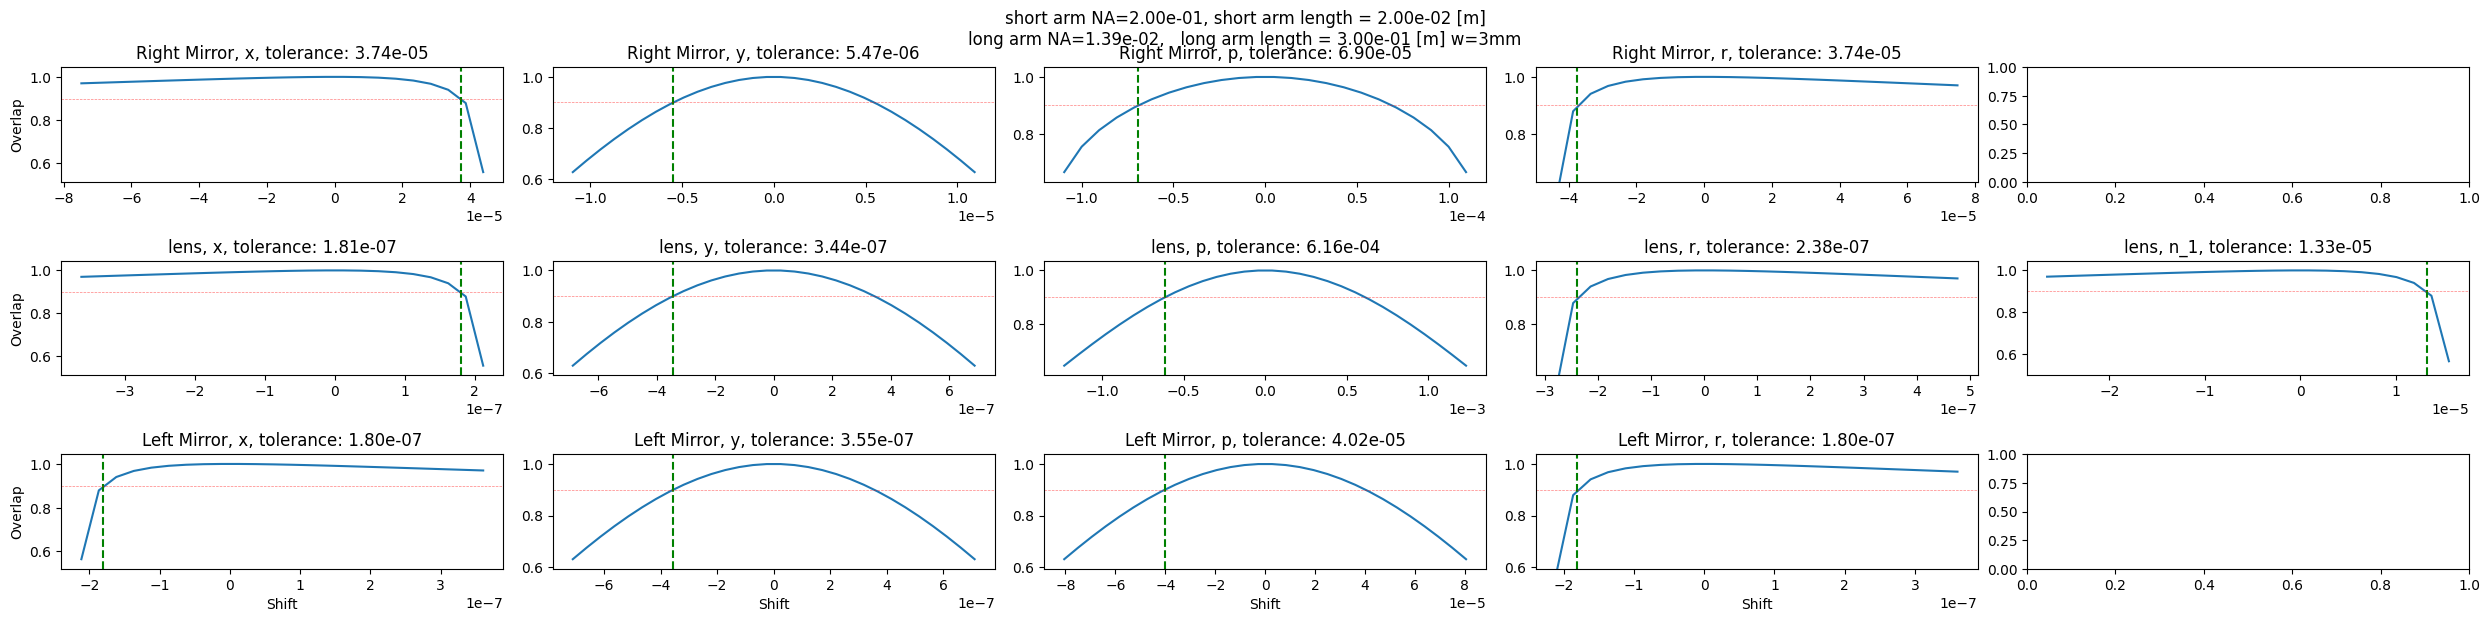

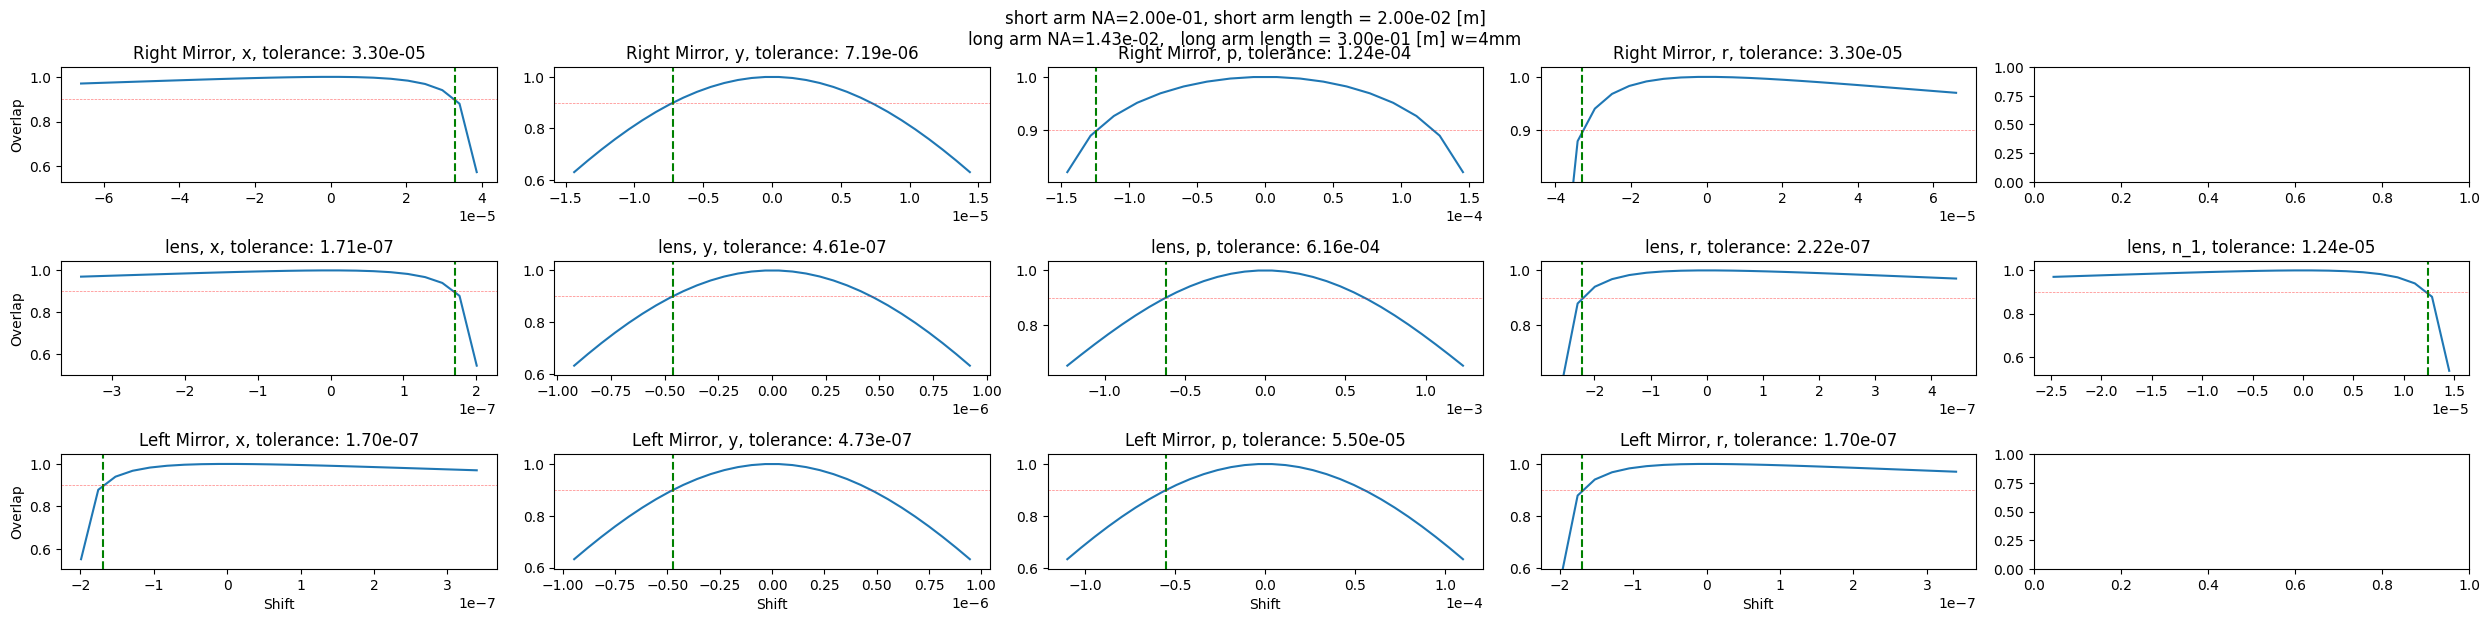

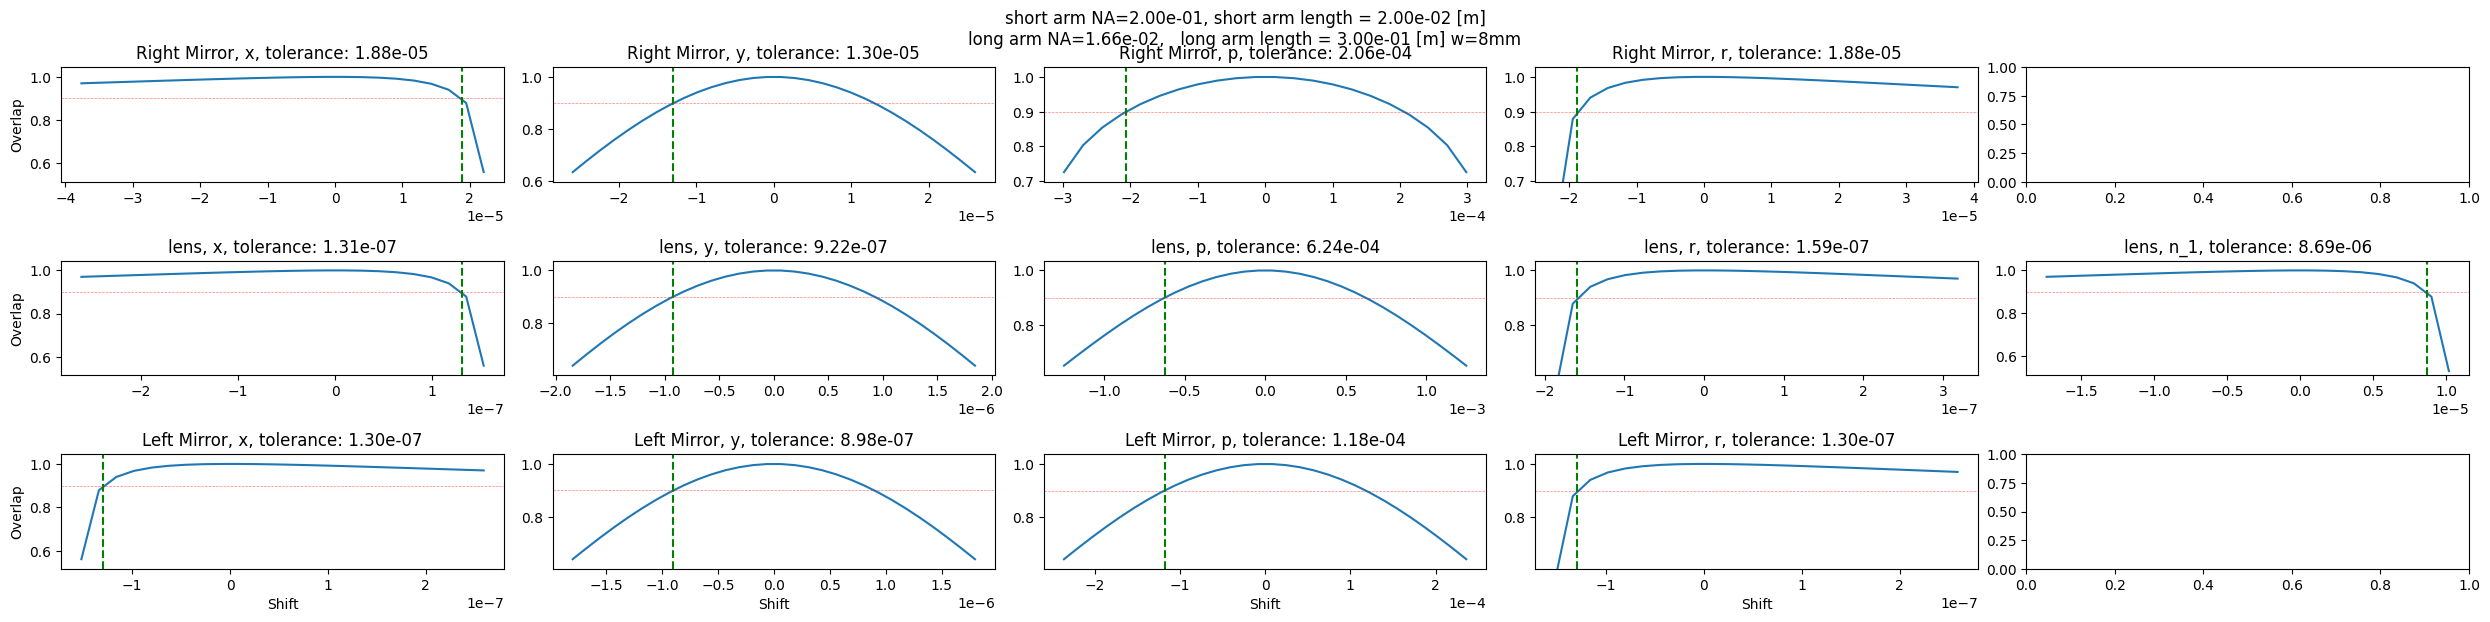

In [4]:
for w in ['3mm', '4mm', '8mm']:
    params = params_dict[f'Sapphire, NA=0.2, L1=0.3, w={w} - distances from lens center']


    mirror_on_waist = True
    auto_set_axes = 1.0000000000e+00
    axis_span = None
    camera_center = -1
    lambda_laser = 1064e-9
    names = ['Right Mirror', 'lens', 'Left Mirror']

    cavity = Cavity.from_params(params=params, standing_wave=True,
                                lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)

    title = f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(params[1, 0] - cavity.surfaces[3].center):.2e} [m]\n" + \
            f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e},   long arm length = {np.linalg.norm(params[1, 0] - cavity.surfaces[0].center):.2e} [m] w={w}"
    
    # fig, ax = plt.subplots(figsize=(13, 5))
    # cavity.plot(axis_span=axis_span, camera_center=camera_center, ax=ax, plane='xz')  #
    # ax.set_title(title)
    # plt.savefig(
    #     f'figures/systems/mirror-lens-mirror_high_NA_ratio_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} w={w} {systems_names[i]}.svg',
    #     dpi=300, bbox_inches='tight')
    # plt.show()
    # %%
    tolerance_matrix = cavity.generate_tolerance_threshold_matrix(print_progress=False)

    # %%
    overlaps_series = cavity.generate_overlap_series(shifts=2 * np.abs(tolerance_matrix[:, :]),
                                                     shift_size=30,
                                                     print_progress=False)

    # %%
    cavity.generate_overlaps_graphs(overlaps_series=overlaps_series, tolerance_matrix=tolerance_matrix[:, :],
                                    arm_index_for_NA=2)
    plt.suptitle(title)
    # plt.savefig(f'figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_smart_choice_tolerance_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(params[1, 0] - cavity.surfaces[0].center):.2e} w={w}.svg',
    #     dpi=300, bbox_inches='tight')
    plt.show()

### Comparing different lens's width, lengths measured from len's edges:

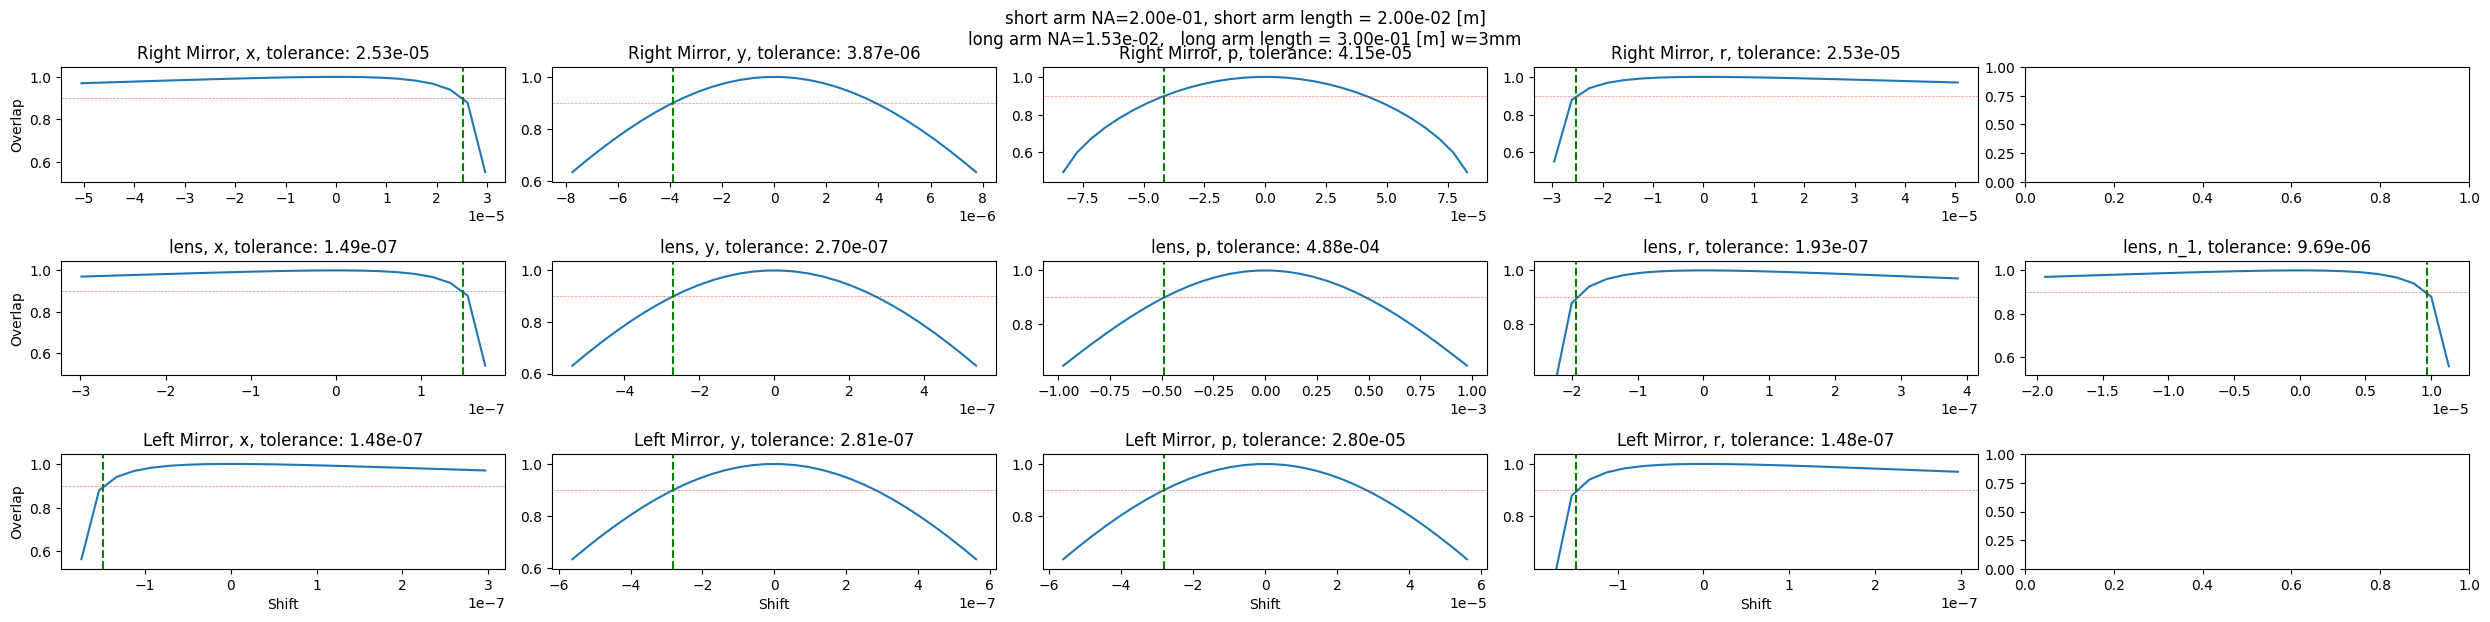

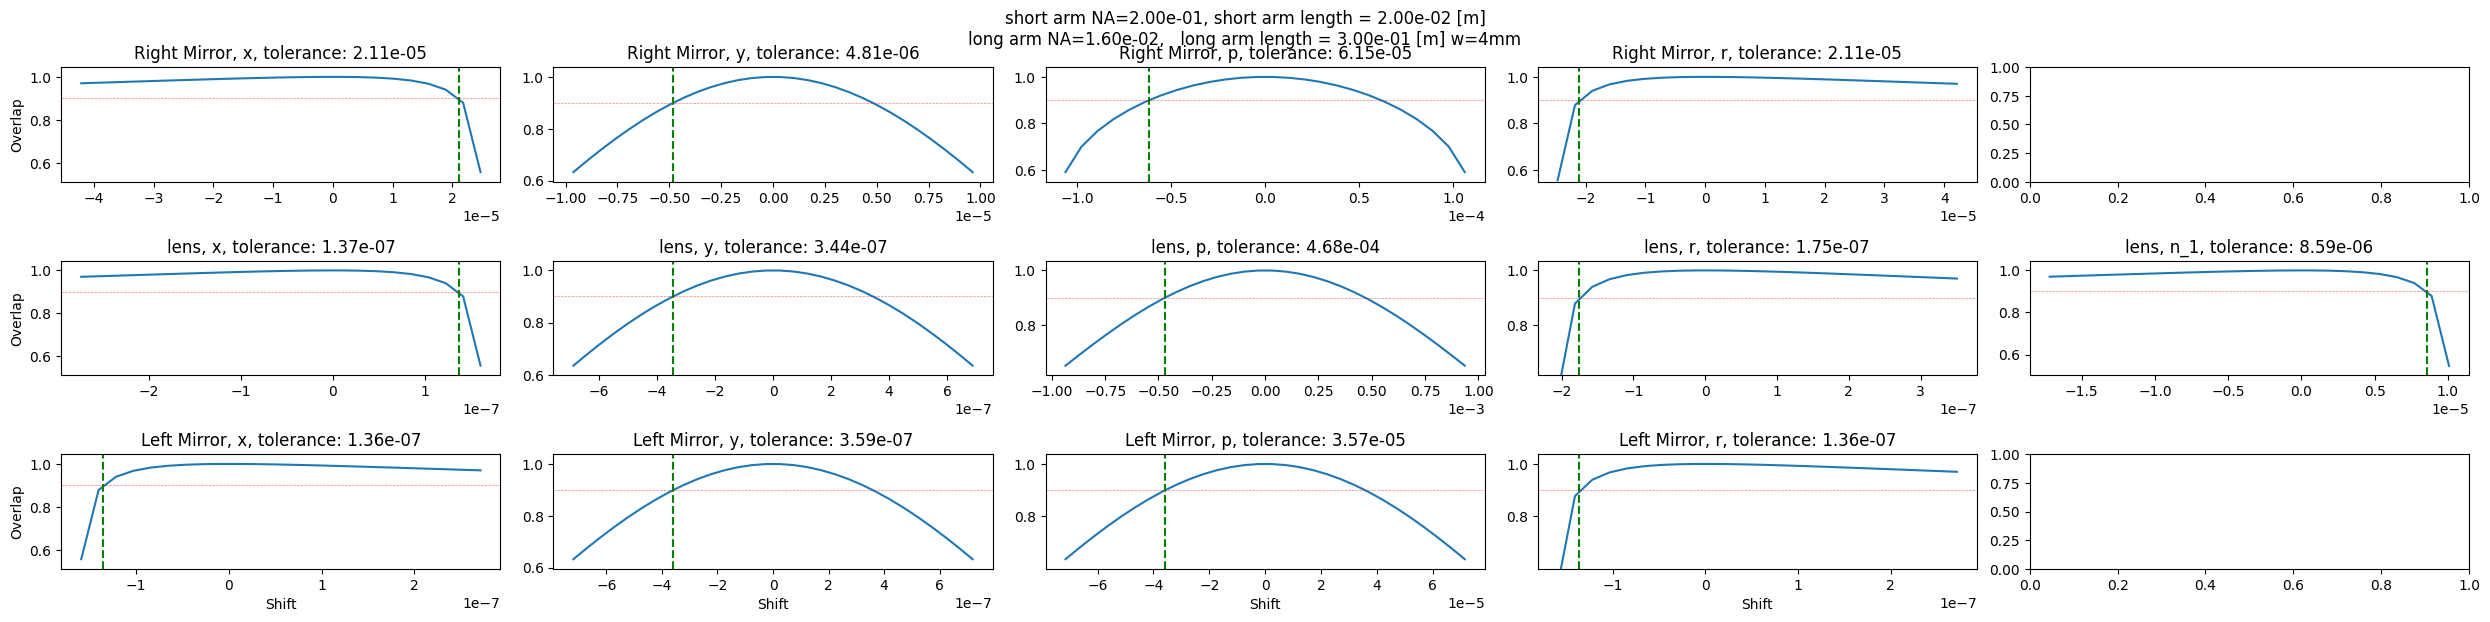

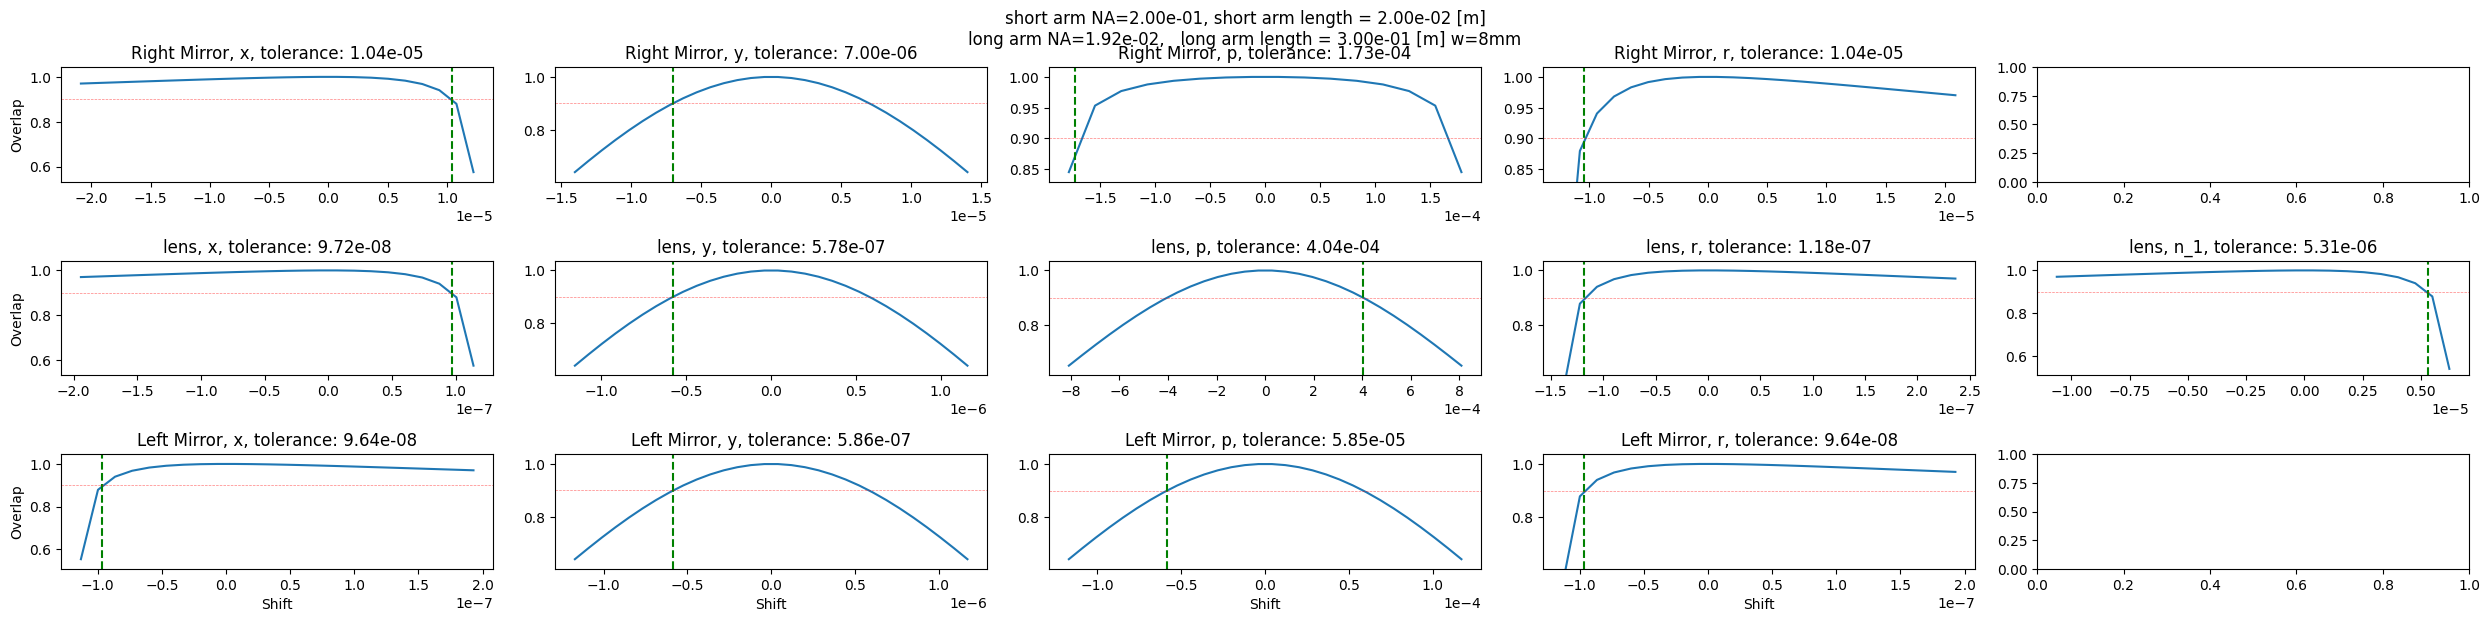

In [5]:
for w in ['3mm', '4mm', '8mm']:
    params = params_dict[f'Sapphire, NA=0.2, L1=0.3, w={w} - High NA axis']


    mirror_on_waist = True
    auto_set_axes = 1.0000000000e+00
    axis_span = None
    camera_center = -1
    lambda_laser = 1064e-9
    names = ['Right Mirror', 'lens', 'Left Mirror']

    cavity = Cavity.from_params(params=params, standing_wave=True,
                                lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)

    title = f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.2e} [m]\n" + \
        f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e},   long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} [m] w={w}"
    
    # fig, ax = plt.subplots(figsize=(13, 5))
    # cavity.plot(axis_span=axis_span, camera_center=camera_center, ax=ax, plane='xz')  #
    # ax.set_title(title)
    # plt.savefig(
    #     f'figures/systems/mirror-lens-mirror_high_NA_ratio_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e} w={w} {systems_names[i]}.svg',
    #     dpi=300, bbox_inches='tight')
    # plt.show()
    # %%
    tolerance_matrix = cavity.generate_tolerance_threshold_matrix(print_progress=False)

    # %%
    overlaps_series = cavity.generate_overlap_series(shifts=2 * np.abs(tolerance_matrix[:, :]),
                                                     shift_size=30,
                                                     print_progress=False)

    # %%
    cavity.generate_overlaps_graphs(overlaps_series=overlaps_series, tolerance_matrix=tolerance_matrix[:, :],
                                    arm_index_for_NA=2)
    plt.suptitle(title)
    # plt.savefig(f'figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_smart_choice_tolerance_NA_1_{cavity.arms[0].mode_parameters.NA[0]:.2e}_L_1_{np.linalg.norm(params[1, 0] - cavity.surfaces[0].center):.2e} w={w}.svg',
    #     dpi=300, bbox_inches='tight')
    plt.show()

### Calculate minimal thickness of a lens:

0.003316036035524063


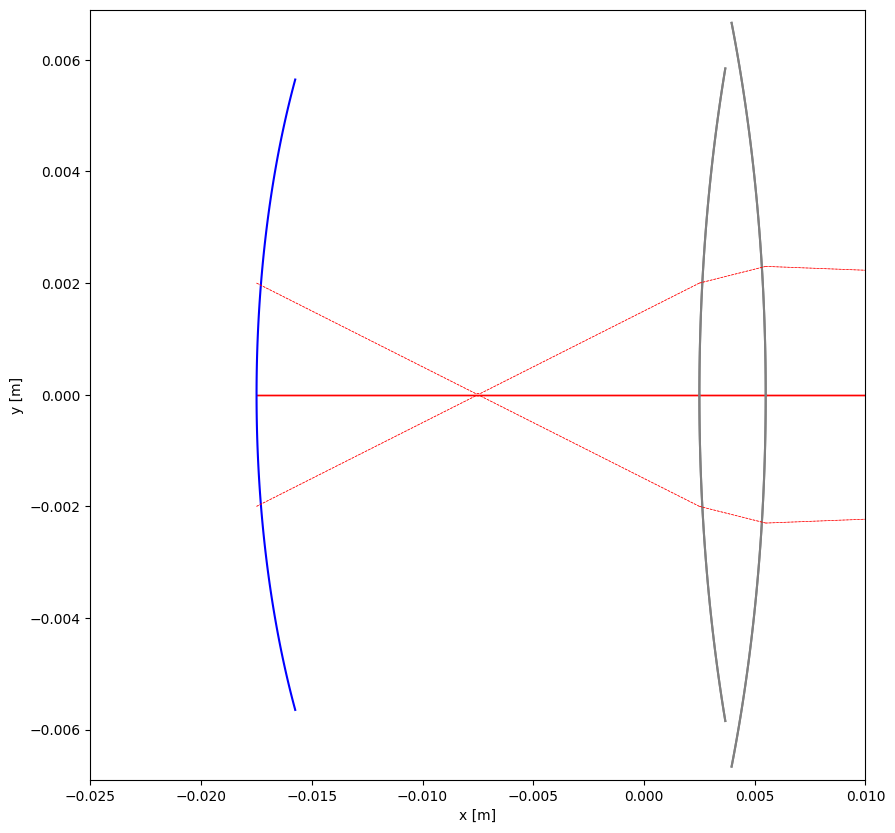

In [5]:
params = params_dict[f'Sapphire, NA=0.2, L1=0.3, w=3mm - High NA axis']
lambda_laser = 1064e-9
names = ['Right Mirror', 'lens', 'Left Mirror']

cavity = Cavity.from_params(params=params, standing_wave=True,
                            lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)

cavity.plot()
plt.xlim(-0.025, 0.01)
R = np.real(params[1, INDICES_DICT['r']])
spot_size = cavity.arms[0].mode_parameters_on_surface_2.spot_size(cavity.lambda_laser)[0]
h = 3 * spot_size
d = R * (1 - np.sqrt(1- h**2 / R**2))
alpha = np.arcsin(h / R)
d_alternative = R * (1 - np.cos(alpha))
print(2*d)

params[1, 4] = 2*d+1e-3


In [12]:
font = {'size'   : 10}
rc('font', **font)
lambda_laser = 1.064e-6


def f(power, waist_to_left_mirror, symmetric_left_arm, mode_3_center, mode_3_center_fine, x_2, x_2_perturbation, NA_3, right_arm_length, right_mirror_radius_shift, right_mirror_position_shift, auto_set_right_arm_length,
      mirror_on_waist, R, R_small_perturbation, w, w_small_perturbation, n, lens_thermal_properties_override, lens_fixed_properties, alpha_lens,
      beta_lens, kappa_lens, dn_dT_lens, nu_lens, alpha_absorption_lens, auto_set_x, x_span, auto_set_y, y_span, camera_center,
      print_input_parameters, print_parameters):

    if print_input_parameters:
        print_parameters_func(locals())
    
    R = 10 ** R
    R += R_small_perturbation
    w = 10 ** w
    w += w_small_perturbation
    right_arm_length = 10 ** right_arm_length
    x_span = 10 ** x_span
    y_span = 10 ** y_span
    mode_3_center += mode_3_center_fine
    # Generate left arm's mirror:
    z_R_3 = lambda_laser / (np.pi * NA_3 ** 2)
    if symmetric_left_arm:
        half_length = (x_2 - w/2) - mode_3_center
        x_3 = mode_3_center - half_length
    else:
        x_3 = mode_3_center - waist_to_left_mirror
    mode_3_center = np.array([mode_3_center, 0, 0])
    mode_3_k_vector = np.array([1, 0, 0])
    mode_3 = ModeParameters(center=np.stack([mode_3_center, mode_3_center], axis=0), k_vector=mode_3_k_vector,
                            z_R=np.array([z_R_3, z_R_3]),
                            principle_axes=np.array([[0, 0, 1], [0, 1, 0]]), lambda_laser=lambda_laser)
    mirror_3 = match_a_mirror_to_mode(mode_3, x_3 - mode_3.center[0, 0], PHYSICAL_SIZES_DICT['thermal_properties_ULE'])

    # Generate lens:
    if lens_thermal_properties_override:
        alpha_lens, beta_lens, kappa_lens, dn_dT_lens, nu_lens, alpha_absorption_lens = PHYSICAL_SIZES_DICT[
            f"thermal_properties_{lens_fixed_properties}"].to_array
        n = PHYSICAL_SIZES_DICT['refractive_indices'][lens_fixed_properties]
    lens_params = np.array(
        [x_2, 0, 0, 0, R, n, w, 1, 0, 0, alpha_lens, beta_lens, kappa_lens, dn_dT_lens, nu_lens, alpha_absorption_lens,
         1])
    surface_3, surface_1 = generate_lens_from_params(lens_params, names=['lens_left', 'lens_right'])
    local_mode_3 = mode_3.local_mode_parameters(np.linalg.norm(surface_3.center - mode_3.center[0]))
    local_mode_1 = local_mode_2_of_lens_parameters(np.array([R, w, n]), local_mode_3)
    mode_1 = local_mode_1.to_mode_parameters(location_of_local_mode_parameter=surface_1.center,
                                             k_vector=mode_3_k_vector, lambda_laser=lambda_laser)

    if auto_set_right_arm_length:
        z_minus_z_0 = - local_mode_1.z_minus_z_0[0]
    elif mirror_on_waist:
        z_minus_z_0 = 0
    else:
        z_minus_z_0 = local_mode_1.z_minus_z_0[0] + right_arm_length

    mirror_1 = match_a_mirror_to_mode(mode_1, z_minus_z_0, PHYSICAL_SIZES_DICT['thermal_properties_ULE'])
    mirror_1.radius += right_mirror_radius_shift
    mirror_1.origin += np.array([right_mirror_position_shift-right_mirror_radius_shift, 0, 0])
    mirror_3_params = mirror_3.to_params
    mirror_1_params = mirror_1.to_params
    lens_params = lens_params.astype(np.complex128)
    lens_params[3] = 1j
    params = np.stack([mirror_1_params, lens_params, mirror_3_params], axis=0)
    params[1, 0] += x_2_perturbation

    cavity = Cavity.from_params(params,
                                lambda_laser=lambda_laser,
                                standing_wave=True,
                                p_is_trivial=True,
                                t_is_trivial=True,
                                set_mode_parameters=True,
                                names=['Left mirror', 'Lens_left', 'lens_right', 'Right mirror'],
                                power=power)
    unheated_cavity = cavity.thermal_transformation()
    fig, ax = plt.subplots(2, 1, figsize=(12, 12))
    cavity.plot(axis_span=x_span, camera_center=camera_center, ax=ax[1])
    ax[1].set_title(
        f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.3e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.3e} [m]\n"  # 
        f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.3e}, long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.3e} [m]\n"  # 
        f"R_left={mirror_3.radius:.2e} R_lens = {R:.2e}, w_lens={w:.3e}, {n=:.2e}, R_right={mirror_1.radius:.2e}, spot size={2*cavity.arms[2].mode_parameters_on_surface_2.spot_size(cavity.lambda_laser)[0]:.2e}")
    plt.grid()
    if auto_set_x:
        cavity_length = mirror_1.center[0] - mirror_3.center[0]
        ax[1].set_xlim(mirror_3.center[0] - 0.01 * cavity_length, mirror_1.center[0] + 0.01 * cavity_length)
    if auto_set_y:
        y_lim = maximal_lens_height(R, w) * 1.1
    else:
        y_lim = y_span
    ax[1].set_ylim(-y_lim, y_lim)
    if print_parameters:
        print(f"{params=}")
    unheated_cavity.plot(axis_span=x_span, camera_center=camera_center, ax=ax[0])
    ax[0].set_xlim(ax[1].get_xlim())
    ax[0].set_ylim(ax[1].get_ylim())
    ax[0].set_title(
        f"unheated_cavity, short arm NA={unheated_cavity.arms[2].mode_parameters.NA[0]:.2e}, Left spot size = {2*unheated_cavity.arms[2].mode_parameters_on_surface_1.spot_size(lambda_laser=1064e-9)[0]:.2e}")
    plt.subplots_adjust(hspace=0.35)
    plt.show()


dx=1e-9
alpha_sapphire, beta_sapphire, kappa_sapphire, dn_dT_sapphire, nu_sapphire, alpha_absorption_sapphire = PHYSICAL_SIZES_DICT['thermal_properties_sapphire'].to_array
alpha_fused_silica, beta_fused_silica, kappa_fused_silica, dn_dT_fused_silica, nu_fused_silica, alpha_absorption_fused_silica = PHYSICAL_SIZES_DICT['thermal_properties_fused_silica'].to_array



widgets.interact(f,
                 power=FloatSlider(value=50000, min=100, max=100000, step=dx, description='power', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 waist_to_left_mirror=FloatSlider(value=0.01, min=0.005, max=0.04, step=dx, description='x_waist - x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 symmetric_left_arm=widgets.Checkbox(value=True, description='Symmetric left arm', disabled=False),
                 mode_3_center=FloatSlider(value=-0.008154, min=-0.02, max=0, step=dx, description='left waist', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 mode_3_center_fine=FloatSlider(value=-1e-5, min=-1e-5, max=1e-5, step=dx, description='left waist_fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 NA_3=FloatSlider(value=0.2, min=0.001, max=0.2, step=dx, description='NA left', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=4e-3, min=-1e-2, max=1e-2, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_perturbation=FloatSlider(value=0, min=-1e-3, max=1e-3, step=dx, description='x_2_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 R=FloatSlider(value=-1.806438, min=-2.5, max=-1.5, step=dx, description='Lens radius', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 R_small_perturbation=FloatSlider(value=0, min=-1e-4, max=1e-4, step=dx, description='Lens radius fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w=FloatSlider(value=-2.3635, min=-4, max=-1, step=dx, description='Lens width', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_small_perturbation=FloatSlider(value=0, min=-1e-4, max=1e-4, step=dx, description='Lens width fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n=FloatSlider(value=PHYSICAL_SIZES_DICT['refractive_indices']['sapphire'], min=PHYSICAL_SIZES_DICT['refractive_indices']['fused_silica'], max=PHYSICAL_SIZES_DICT['refractive_indices']['sapphire'], step=dx, description='Len n', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 right_arm_length=FloatSlider(value=-1, min=-6, max=1.3, step=dx, description='Right arm length', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_right_arm_length=widgets.Checkbox(value=True, description='Auto set right arm length', disabled=False),
                 mirror_on_waist=widgets.Checkbox(value=False, description='Place right mirror on waist', disabled=False),
                 right_mirror_radius_shift=FloatSlider(value=0, min=0, max=2e-1, step=dx, description='delta_R_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 right_mirror_position_shift=FloatSlider(value=0, min=-1e-1, max=1e-1, step=dx, description='delta_x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lens_thermal_properties_override=widgets.Checkbox(value=True, description='Override lens properties', disabled=False),
                 lens_fixed_properties=widgets.Dropdown(options=[('Fused Silica', 'fused_silica'), ('Sapphire', 'sapphire')], value='sapphire', description='Override lens properties with:',),
                 alpha_lens=FloatSlider(value=alpha_sapphire, min=alpha_fused_silica, max=alpha_sapphire, step=dx, description='alpha_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 beta_lens=FloatSlider(value=beta_sapphire, min=beta_sapphire, max=beta_sapphire, step=dx, description='beta_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 kappa_lens=FloatSlider(value=kappa_sapphire, min=kappa_fused_silica, max=kappa_sapphire, step=dx, description='kappa_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dn_dT_lens=FloatSlider(value=dn_dT_sapphire, min=dn_dT_sapphire, max=dn_dT_fused_silica, step=dx, description='dn_dT_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 nu_lens=FloatSlider(value=nu_sapphire, min=nu_fused_silica, max=nu_sapphire, step=dx, description='nu_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 alpha_absorption_lens=FloatSlider(value=alpha_absorption_sapphire, min=alpha_absorption_fused_silica, max=alpha_absorption_sapphire, step=dx, description='alpha_absorption_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_x=widgets.Checkbox(value=True, description='Auto set x', disabled=False),
                 x_span=FloatSlider(value=-1, min=-5, max=1.3, step=0.01, description='x span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_y=widgets.Checkbox(value=True, description='Auto set y', disabled=False),
                 y_span=FloatSlider(value=-2.9, min=-4, max=-2, step=0.01, description='y span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=2, description='Focus on mirror:',),
                 print_input_parameters=widgets.Checkbox(value=False, description='Print input parameters', disabled=False),
                 print_parameters=widgets.Checkbox(value=False, description='Print parameters', disabled=False),
                 );

interactive(children=(FloatSlider(value=50000.0, description='power', layout=Layout(width='2000px'), max=10000…

In [17]:
font = {'size'   : 10}
rc('font', **font)
lambda_laser = 1.064e-6


def f(power, waist_to_left_mirror, symmetric_left_arm, mode_3_center, mode_3_center_fine, x_2, x_2_perturbation, NA_3, right_arm_length, right_mirror_radius_shift, right_mirror_position_shift, auto_set_right_arm_length,
      mirror_on_waist, R, R_small_perturbation, w, w_small_perturbation, n, lens_thermal_properties_override, lens_fixed_properties, alpha_lens,
      beta_lens, kappa_lens, dn_dT_lens, nu_lens, alpha_absorption_lens, auto_set_x, x_span, auto_set_y, y_span, camera_center,
      print_input_parameters, print_parameters):

    if print_input_parameters:
        print_parameters_func(locals())
    
    R = 10 ** R
    R += R_small_perturbation
    w = 10 ** w
    w += w_small_perturbation
    right_arm_length = 10 ** right_arm_length
    x_span = 10 ** x_span
    y_span = 10 ** y_span
    mode_3_center += mode_3_center_fine
    # Generate left arm's mirror:
    z_R_3 = lambda_laser / (np.pi * NA_3 ** 2)
    if symmetric_left_arm:
        half_length = (x_2 - w/2) - mode_3_center
        x_3 = mode_3_center - half_length
    else:
        x_3 = mode_3_center - waist_to_left_mirror
    mode_3_center = np.array([mode_3_center, 0, 0])
    mode_3_k_vector = np.array([1, 0, 0])
    mode_3 = ModeParameters(center=np.stack([mode_3_center, mode_3_center], axis=0), k_vector=mode_3_k_vector,
                            z_R=np.array([z_R_3, z_R_3]),
                            principle_axes=np.array([[0, 0, 1], [0, 1, 0]]), lambda_laser=lambda_laser)
    mirror_3 = match_a_mirror_to_mode(mode_3, x_3 - mode_3.center[0, 0], PHYSICAL_SIZES_DICT['thermal_properties_ULE'])

    # Generate lens:
    if lens_thermal_properties_override:
        alpha_lens, beta_lens, kappa_lens, dn_dT_lens, nu_lens, alpha_absorption_lens = PHYSICAL_SIZES_DICT[
            f"thermal_properties_{lens_fixed_properties}"].to_array
        n = PHYSICAL_SIZES_DICT['refractive_indices'][lens_fixed_properties]
    lens_params = np.array(
        [x_2, 0, 0, 0, R, n, w, 1, 0, 0, alpha_lens, beta_lens, kappa_lens, dn_dT_lens, nu_lens, alpha_absorption_lens,
         1])
    surface_3, surface_1 = generate_lens_from_params(lens_params, names=['lens_left', 'lens_right'])
    local_mode_3 = mode_3.local_mode_parameters(np.linalg.norm(surface_3.center - mode_3.center[0]))
    local_mode_1 = local_mode_2_of_lens_parameters(np.array([R, w, n]), local_mode_3)
    mode_1 = local_mode_1.to_mode_parameters(location_of_local_mode_parameter=surface_1.center,
                                             k_vector=mode_3_k_vector, lambda_laser=lambda_laser)

    if auto_set_right_arm_length:
        z_minus_z_0 = - local_mode_1.z_minus_z_0[0]
    elif mirror_on_waist:
        z_minus_z_0 = 0
    else:
        z_minus_z_0 = local_mode_1.z_minus_z_0[0] + right_arm_length

    mirror_1 = match_a_mirror_to_mode(mode_1, z_minus_z_0, PHYSICAL_SIZES_DICT['thermal_properties_ULE'])
    mirror_1.radius += right_mirror_radius_shift
    mirror_1.origin += np.array([right_mirror_position_shift-right_mirror_radius_shift, 0, 0])
    mirror_3_params = mirror_3.to_params
    mirror_1_params = mirror_1.to_params
    lens_params = lens_params.astype(np.complex128)
    lens_params[3] = 1j
    params = np.stack([mirror_1_params, lens_params, mirror_3_params], axis=0)
    params[1, 0] += x_2_perturbation

    cavity = Cavity.from_params(params,
                                lambda_laser=lambda_laser,
                                standing_wave=True,
                                p_is_trivial=True,
                                t_is_trivial=True,
                                set_mode_parameters=True,
                                names=['Left mirror', 'Lens_left', 'lens_right', 'Right mirror'],
                                power=power)
    unheated_cavity = cavity.thermal_transformation()
    fig, ax = plt.subplots(2, 1, figsize=(12, 12))
    cavity.plot(axis_span=x_span, camera_center=camera_center, ax=ax[1])
    ax[1].set_title(
        f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.3e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.3e} [m]\n"  # 
        f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.3e}, long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.3e} [m]\n"  # 
        f"R_left={mirror_3.radius:.2e} R_lens = {R:.2e}, w_lens={w:.3e}, {n=:.2e}, R_right={mirror_1.radius:.2e}, spot size={2*cavity.arms[2].mode_parameters_on_surface_2.spot_size(cavity.lambda_laser)[0]:.2e}")
    plt.grid()
    if auto_set_x:
        cavity_length = mirror_1.center[0] - mirror_3.center[0]
        ax[1].set_xlim(mirror_3.center[0] - 0.01 * cavity_length, mirror_1.center[0] + 0.01 * cavity_length)
    if auto_set_y:
        y_lim = maximal_lens_height(R, w) * 1.1
    else:
        y_lim = y_span
    ax[1].set_ylim(-y_lim, y_lim)
    if print_parameters:
        print(f"{params=}")
    unheated_cavity.plot(axis_span=x_span, camera_center=camera_center, ax=ax[0])
    ax[0].set_xlim(ax[1].get_xlim())
    ax[0].set_ylim(ax[1].get_ylim())
    ax[0].set_title(
        f"unheated_cavity, short arm NA={unheated_cavity.arms[2].mode_parameters.NA[0]:.2e}, Left spot size = {2*unheated_cavity.arms[2].mode_parameters_on_surface_1.spot_size(lambda_laser=1064e-9)[0]:.2e}")
    plt.subplots_adjust(hspace=0.35)
    plt.show()


dx=1e-9
alpha_sapphire, beta_sapphire, kappa_sapphire, dn_dT_sapphire, nu_sapphire, alpha_absorption_sapphire = PHYSICAL_SIZES_DICT['thermal_properties_sapphire'].to_array
alpha_fused_silica, beta_fused_silica, kappa_fused_silica, dn_dT_fused_silica, nu_fused_silica, alpha_absorption_fused_silica = PHYSICAL_SIZES_DICT['thermal_properties_fused_silica'].to_array



widgets.interact(f,
                 power=FloatSlider(value=50000, min=100, max=100000, step=dx, description='power', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 waist_to_left_mirror=FloatSlider(value=0.01, min=0.005, max=0.04, step=dx, description='x_waist - x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 symmetric_left_arm=widgets.Checkbox(value=True, description='Symmetric left arm', disabled=False),
                 mode_3_center=FloatSlider(value=-0.008154, min=-0.02, max=0, step=dx, description='left waist', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 mode_3_center_fine=FloatSlider(value=-1e-5, min=-1e-5, max=1e-5, step=dx, description='left waist_fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 NA_3=FloatSlider(value=0.2, min=0.001, max=0.2, step=dx, description='NA left', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=4e-3, min=-1e-2, max=1e-2, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_perturbation=FloatSlider(value=0, min=-1e-3, max=1e-3, step=dx, description='x_2_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 R=FloatSlider(value=-1.806438, min=-2.5, max=-1.5, step=dx, description='Lens radius', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 R_small_perturbation=FloatSlider(value=0, min=-1e-4, max=1e-4, step=dx, description='Lens radius fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w=FloatSlider(value=-2.3635, min=-4, max=-1, step=dx, description='Lens width', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_small_perturbation=FloatSlider(value=0, min=-1e-4, max=1e-4, step=dx, description='Lens width fine', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n=FloatSlider(value=PHYSICAL_SIZES_DICT['refractive_indices']['sapphire'], min=PHYSICAL_SIZES_DICT['refractive_indices']['fused_silica'], max=PHYSICAL_SIZES_DICT['refractive_indices']['sapphire'], step=dx, description='Len n', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 right_arm_length=FloatSlider(value=-1, min=-6, max=1.3, step=dx, description='Right arm length', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_right_arm_length=widgets.Checkbox(value=True, description='Auto set right arm length', disabled=False),
                 mirror_on_waist=widgets.Checkbox(value=False, description='Place right mirror on waist', disabled=False),
                 right_mirror_radius_shift=FloatSlider(value=0, min=0, max=2e-1, step=dx, description='delta_R_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 right_mirror_position_shift=FloatSlider(value=0, min=-1e-1, max=1e-1, step=dx, description='delta_x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lens_thermal_properties_override=widgets.Checkbox(value=True, description='Override lens properties', disabled=False),
                 lens_fixed_properties=widgets.Dropdown(options=[('Fused Silica', 'fused_silica'), ('Sapphire', 'sapphire')], value='sapphire', description='Override lens properties with:',),
                 alpha_lens=FloatSlider(value=alpha_sapphire, min=alpha_fused_silica, max=alpha_sapphire, step=dx, description='alpha_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 beta_lens=FloatSlider(value=0, min=0, max=beta_sapphire, step=dx, description='beta_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 kappa_lens=FloatSlider(value=kappa_sapphire, min=kappa_fused_silica, max=kappa_sapphire, step=dx, description='kappa_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dn_dT_lens=FloatSlider(value=0, min=0, max=dn_dT_fused_silica, step=dx, description='dn_dT_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 nu_lens=FloatSlider(value=nu_sapphire, min=nu_fused_silica, max=nu_sapphire, step=dx, description='nu_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 alpha_absorption_lens=FloatSlider(value=alpha_absorption_sapphire, min=alpha_absorption_fused_silica, max=alpha_absorption_sapphire, step=dx, description='alpha_absorption_lens', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_x=widgets.Checkbox(value=True, description='Auto set x', disabled=False),
                 x_span=FloatSlider(value=-1, min=-5, max=1.3, step=0.01, description='x span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 auto_set_y=widgets.Checkbox(value=True, description='Auto set y', disabled=False),
                 y_span=FloatSlider(value=-2.9, min=-4, max=-2, step=0.01, description='y span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=2, description='Focus on mirror:',),
                 print_input_parameters=widgets.Checkbox(value=False, description='Print input parameters', disabled=False),
                 print_parameters=widgets.Checkbox(value=False, description='Print parameters', disabled=False),
                 );

interactive(children=(FloatSlider(value=50000.0, description='power', layout=Layout(width='2000px'), max=10000…